# Datacuisiniers - Milestone 3

We chose the **[CMU Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/)**. This dataset contains 42,306 movie plot summaries extracted from Wikipedia + aligned metadata extracted from Freebase.

Using this dataset, we want to dive into the **drivers of an actor's success**, following several definitions.

In [75]:
import pandas as pd
import seaborn as sns
sns.set_theme()
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
import ast 
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from scipy.stats import boxcox
import statsmodels.api as sm
from helpers import *
import json

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder


from imblearn.over_sampling import RandomOverSampler
import os
import gzip
from tqdm import tqdm
import xml.etree.ElementTree as ET

## 1. Exploration of the dataset

Many variables of the dataset are relevant to predict the success of an actor or an actress. Some are present in the characters dataset:
- Age at the beginning of their careers
- Age at the time of the movie
- Gender
- Ethnicity
- Height

Some are present in the movie dataset, but would need to be aggregated by actor:
- Movie release date (relative to the first film?): maybe some actors released their average movie during the golden age of the film industry?
- Movie language: maybe some languages allow to touch more people?
- Country of the movie: the country with the most occurence?

Some have to be constructed for this analysis:
- Variety of film genres in which the actor has played
- Variety of roles portrayed with an analysis of personas

### Movies metadata

In [41]:
#movies = pd.read_table('~/ADA2023/Project/Data/MovieSummaries/movie.metadata.tsv', header=None)
movies = pd.read_csv('Data/MovieSummaries/movie.metadata.tsv', sep='\t', header=None)
movies.columns = ['Wikipedia movie ID','Freebase movie ID','Movie name','Movie release date','Movie box office revenue','Movie runtime','Movie languages','Movie countries','Movie genres']
movies.head()

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [42]:
# Remove leading and trailing spaces, then parse the dictionaries
movies['Movie languages'] = movies['Movie languages'].apply(lambda x: ast.literal_eval(x.strip()) if x.strip() else {})
movies['Movie countries'] = movies['Movie countries'].apply(lambda x: ast.literal_eval(x.strip()) if x.strip() else {})
movies['Movie genres'] = movies['Movie genres'].apply(lambda x: ast.literal_eval(x.strip()) if x.strip() else {})

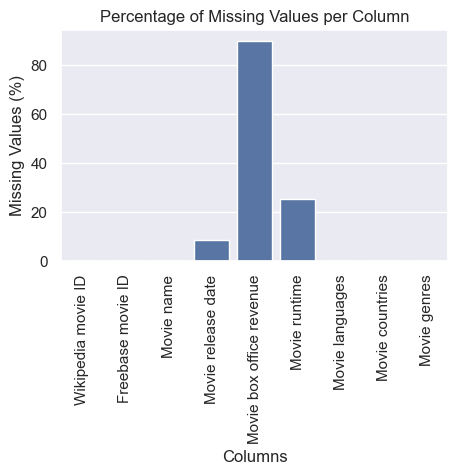

In [44]:
# Count missing values per column
missing_percent = (movies.isna().mean() * 100)

# Create a bar plot
plt.figure(figsize=(5, 3))
sns.barplot(x=missing_percent.index, y=missing_percent.values)
plt.xticks(rotation=90)  
plt.xlabel('Columns')
plt.ylabel('Missing Values (%)')
plt.title('Percentage of Missing Values per Column')
plt.show()

There is a lot of missing values for the variable on movie revenues.

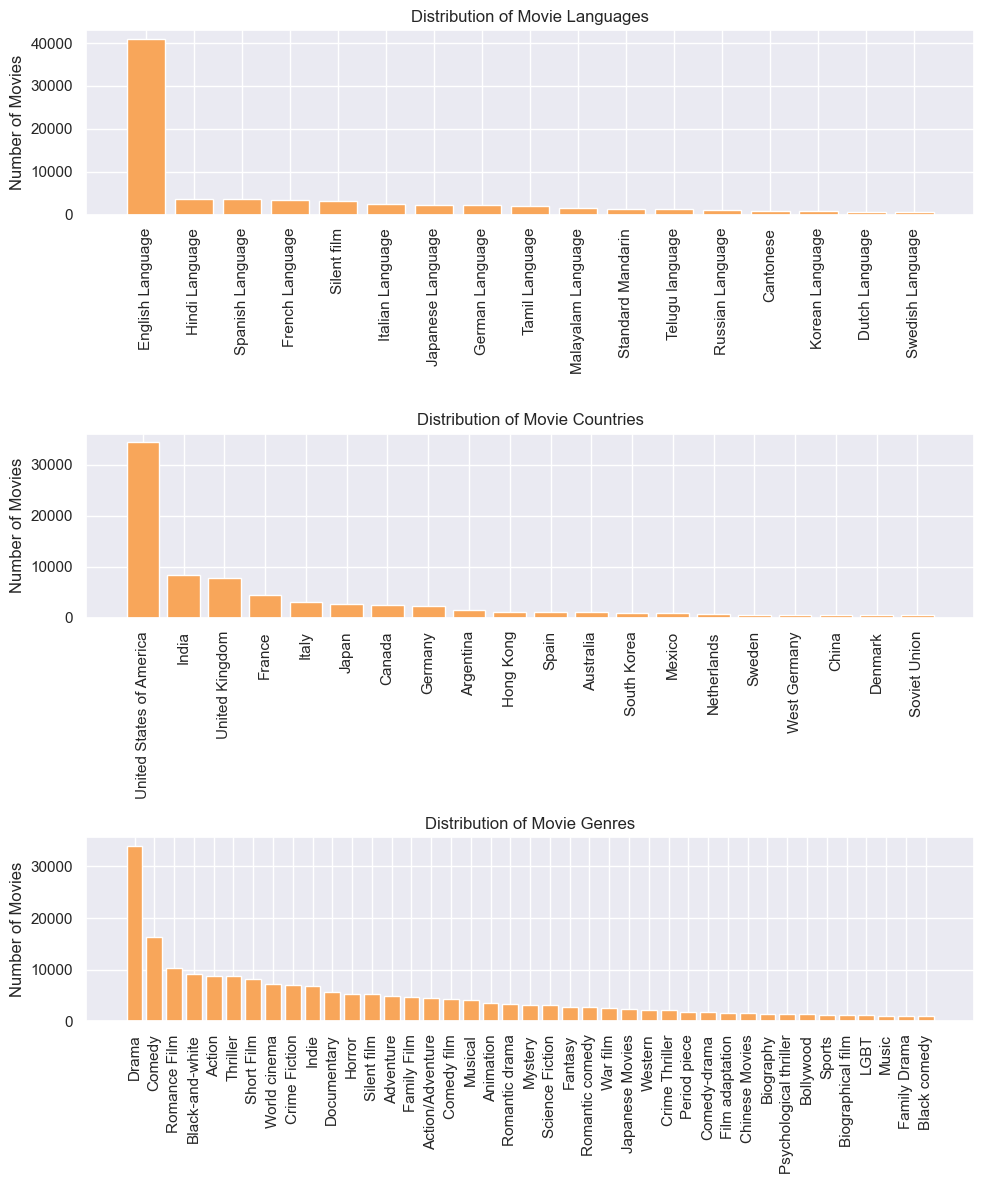

In [45]:
# Flatten the dictionaries and count language occurrences
language_counts = Counter(language for languages_dict in movies["Movie languages"] for language in languages_dict.values())
filtered_language_counts = {language: count for language, count in language_counts.items() if count > 500}
sorted_filtered_language_counts = dict(sorted(filtered_language_counts.items(), key=lambda item: item[1], reverse=True))

# Flatten the dictionaries and count countries occurrences
countries_counts = Counter(country for countries_dict in movies["Movie countries"] for country in countries_dict.values())
filtered_countries_counts = {country: count for country, count in countries_counts.items() if count > 500}
sorted_filtered_countries_counts = dict(sorted(filtered_countries_counts.items(), key=lambda item: item[1], reverse=True))

# Flatten the dictionaries and count genres occurrences
genres_counts = Counter(genre for genres_dict in movies["Movie genres"] for genre in genres_dict.values())
filtered_genres_counts = {genre: count for genre, count in genres_counts.items() if count > 1000}
sorted_filtered_genres_counts = dict(sorted(filtered_genres_counts.items(), key=lambda item: item[1], reverse=True))

fig, axes = plt.subplots(3, 1, figsize=(10, 12))


languages, counts = zip(*sorted_filtered_language_counts.items())
axes[0].bar(languages, counts, color='#f8a65a')
axes[0].set_ylabel('Number of Movies')
axes[0].set_title('Distribution of Movie Languages')
axes[0].tick_params(axis='x', rotation=90)

countries, counts = zip(*sorted_filtered_countries_counts.items())
axes[1].bar(countries, counts, color='#f8a65a')
axes[1].set_ylabel('Number of Movies')
axes[1].set_title('Distribution of Movie Countries')
axes[1].tick_params(axis='x', rotation=90)

genres, counts = zip(*sorted_filtered_genres_counts.items())
axes[2].bar(genres, counts, color='#f8a65a')
axes[2].set_ylabel('Number of Movies')
axes[2].set_title('Distribution of Movie Genres')
axes[2].tick_params(axis='x', rotation=90)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

### Characters metadata

In [46]:
#all_characters = pd.read_table('~/ADA2023/Project/Data/MovieSummaries/character.metadata.tsv', header=None)
all_characters = pd.read_csv('Data/MovieSummaries/character.metadata.tsv', sep='\t', header=None)
all_characters.columns = ['Wikipedia movie ID', 'Freebase movie ID', 'Movie release date','Character name','Actor date of birth','Actor gender','Actor height','Actor ethnicity','Actor name','Actor age at movie release','Freebase character/actor map ID','Freebase character ID','Freebase actor ID']
all_characters.head()

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


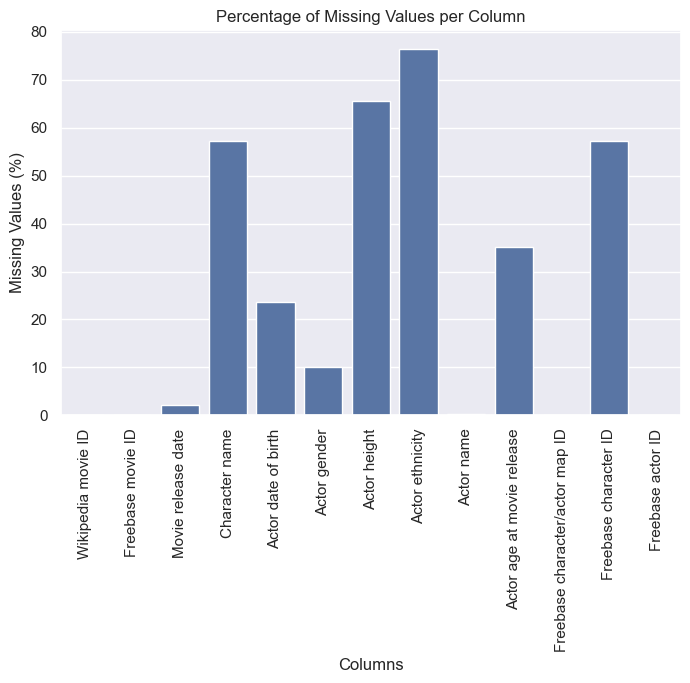

In [47]:
missing_percent = (all_characters.isna().mean() * 100)

plt.figure(figsize=(8, 5))
sns.barplot(x=missing_percent.index, y=missing_percent.values)
plt.xticks(rotation=90)  
plt.xlabel('Columns')
plt.ylabel('Missing Values (%)')
plt.title('Percentage of Missing Values per Column')
plt.show()

There is a lot of missing values in this dataset.

## 2. Persona analysis

In [107]:
#characters_persona = pd.read_csv('~/ADA2023/Project/Data/persona_data.csv')
characters_persona = pd.read_csv('Data/persona_data.csv')
characters_persona = characters_persona.drop(['Unnamed: 0',], axis=1)
characters_persona.rename(columns= {'Actor height (in meters)': 'Actor height', 'Actor ethnicity (Freebase ID)': 'Actor ethnicity'}, inplace= True)

# Merge the dataframes to have all persona with as much info as possible
characters = characters_persona.merge(all_characters, how='right')

## 3. Explaining and measuring success scores

The success can be characterized based on several factors, 
- Longevity: for how long has the actor been in the film industry? 
- In how many films the actor has participated?
- IMDB ratings
- The Oscars
- Google search results
- Film revenue
- Number of film spectators

Some of these indicators require additional datasets. We thus complement our analysis with data on awards, on ratings, and on popularity.

## 3.a. Longevity

In [108]:
column_movies = ["film_id", "movie_id", "title", "release_date", "gross_revenue", "duration_min", "language", "country", "categories"]
movies_df = pd.read_csv('Data/MovieSummaries/movie.metadata.tsv', sep='\t', header=None, names=column_movies)

column_characters = ["film_id", "movie_id", "release_date", "character", "born_date", "gender", "height", "ethnicity", "actor_name", "actor_age_at_movie_release", "actor_map_ID","character_ID","actor_ID"]
character_df = pd.read_csv('Data/MovieSummaries/character.metadata.tsv', sep='\t', header=None, names = column_characters)

### Frequency of presence in movies per year

The first analysis we will focus on is the frequency of appearances in movies per year. In fact, one can interpret a presence in serveral movies in a short period of time as a success factor. The main focus here is to consider frequencies at different periods, different gender and different regions in the world.

In order to avoid to give too much importance to actors who appeared a lot during one year, we could focus on the mean frequency, which discriminates actors that once played in a lot of movies and then appeared way less, and this is a way to measure an entire career factor.

**Simple frequency of presence**

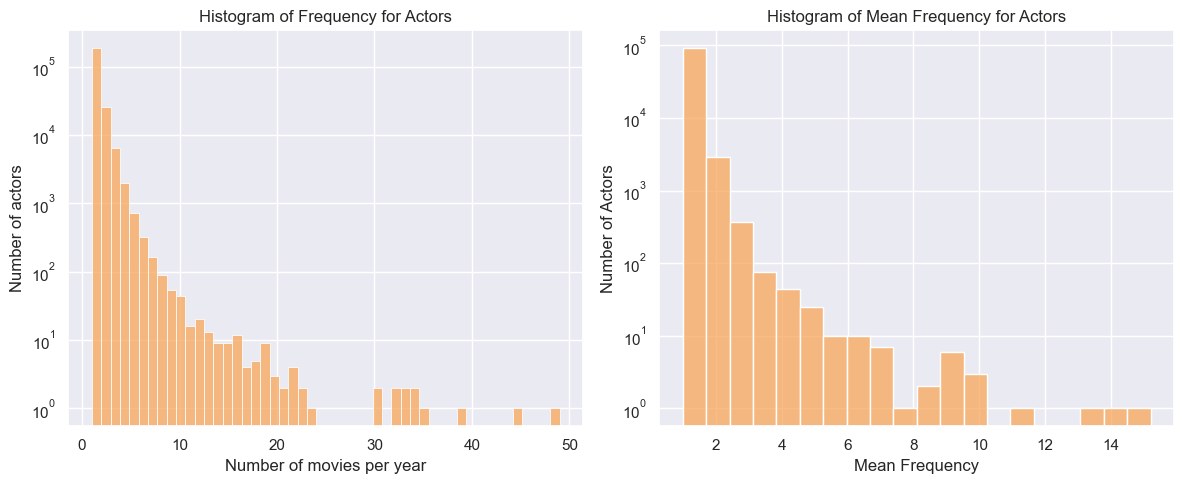

In [109]:
character_df['release_date'] = pd.to_datetime(character_df['release_date'], errors='coerce')

frequency_df = character_df.groupby(['actor_name', character_df['release_date'].dt.year]).size().reset_index(name='movie_count')

frequency_df = frequency_df.merge(character_df[['actor_name', 'gender']], on='actor_name', how='inner')
frequency_df = frequency_df.drop_duplicates(subset=['actor_name', 'release_date'])

count_char_df = pd.merge(character_df, movies_df[['movie_id', 'country']], on='movie_id', how='left')
count_char_df["country"] = (count_char_df["country"].apply(json.loads).apply(format_of_country_change))
count_char_df['region'] = count_char_df['country'].apply(get_region)

frequency_df = frequency_df.merge(count_char_df[['actor_name', 'region']], on='actor_name', how='inner')
frequency_df = frequency_df.drop_duplicates(subset=['actor_name', 'release_date'])

mean_frequency = frequency_df.groupby('actor_name')['movie_count'].mean().reset_index(name='mean_frequency')
mean_frequency = mean_frequency.merge(character_df[['actor_name', 'gender']], on='actor_name', how='inner')
mean_frequency = mean_frequency.merge(count_char_df[['actor_name', 'region']], on='actor_name', how='inner')

mean_frequency = mean_frequency.drop_duplicates(subset=['actor_name'])

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(frequency_df['movie_count'], bins=50, log=True, color='#f8a65a', ax=axs[0])
axs[0].set_ylabel("Number of actors")
axs[0].set_xlabel("Number of movies per year")
axs[0].set_title('Histogram of Frequency for Actors')
axs[0].grid(True)

sns.histplot(mean_frequency['mean_frequency'], bins=20, log=True, kde=False, color='#f8a65a', ax=axs[1])
axs[1].set_xlabel('Mean Frequency')
axs[1].set_ylabel('Number of Actors')
axs[1].set_title('Histogram of Mean Frequency for Actors')
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [110]:
frequency_max = frequency_df.sort_values(by='movie_count', ascending=False)

top5_frequency = frequency_max.head(5)
print("The top actors by frequency per year are :\n\n ",top5_frequency)

top5_actors_mf = mean_frequency.nlargest(5, 'mean_frequency')
print("\n\nAnd the top actors by mean frequency are :\n\n ",top5_actors_mf)

The top actors by frequency per year are :

                actor_name  release_date  movie_count gender         region
2782038  Roscoe Arbuckle        1914.0           49      M  North America
2362269     Oliver Hardy        1916.0           45      M  North America
1129307     Harold Lloyd        1919.0           39      M  North America
2781880  Roscoe Arbuckle        1913.0           35      M  North America
481818   Charlie Chaplin        1914.0           34      M  North America


And the top actors by mean frequency are :

                 actor_name  mean_frequency gender         region
1318450  Charlotte Burton            15.2      F  North America
4985633     Louise Lester            14.0      F  North America
3307334        Jack Davis            13.5    NaN  North America
9607198       Vivian Rich            11.2      F  North America
1185136    Caroline Cooke            10.0      F  North America


It's evident that during the 1910s, the United States produced a majority of male actors, particularly known for their frequent appearances in numerous movies within a single year. However, when considering mean frequency, women from the same period also displayed high participation at that time.

The context of the 1910s is crucial because during this period produced more short-movie, that demanded less effort compared to now-a-days movies. Additionally, the limited pool of available actors resulted in recurring roles for figures like Roscoe Arbuckle, Charlie Chaplin, Oliver Hardy for males, and Charlotte Burton and Louise Lester for females.

This highlights the significance of considering the production period of movies in our assessment, showcasing the distinctive conditions and factors influencing actors' involvement and industry dynamics during that time..

NB : We can filter all the years before 1908 which seems not very insightful, and then plot the average frequency per year with the standard deviation.

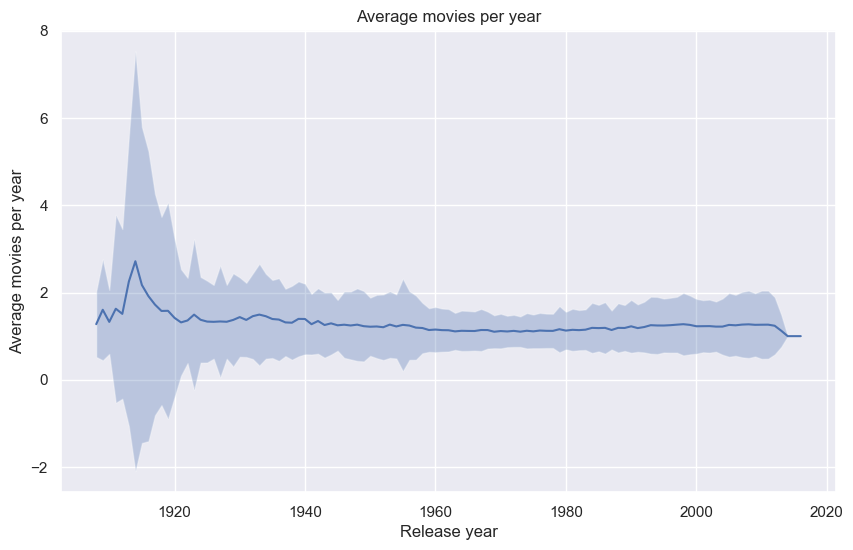

In [52]:
average_movie_count_per_year = frequency_df.groupby('release_date')['movie_count'].agg(['mean', 'std']).reset_index()
average_movie_count_per_year.columns = ['release_date', 'average_movies', 'std_dev']

average_movie_count_per_year = average_movie_count_per_year[average_movie_count_per_year['release_date'] >= 1908]

plt.figure(figsize=(10, 6))
sns.lineplot(data=average_movie_count_per_year, x='release_date', y='average_movies')
plt.fill_between(average_movie_count_per_year['release_date'], 
                 average_movie_count_per_year['average_movies'] - average_movie_count_per_year['std_dev'],
                 average_movie_count_per_year['average_movies'] + average_movie_count_per_year['std_dev'],
                 alpha=0.3)
plt.xlabel('Release year')
plt.ylabel('Average movies per year')
plt.title('Average movies per year')
plt.grid(True)
plt.show()

**Frequency by gender**

We could also focus on gender through time to grasp potential differences over time :

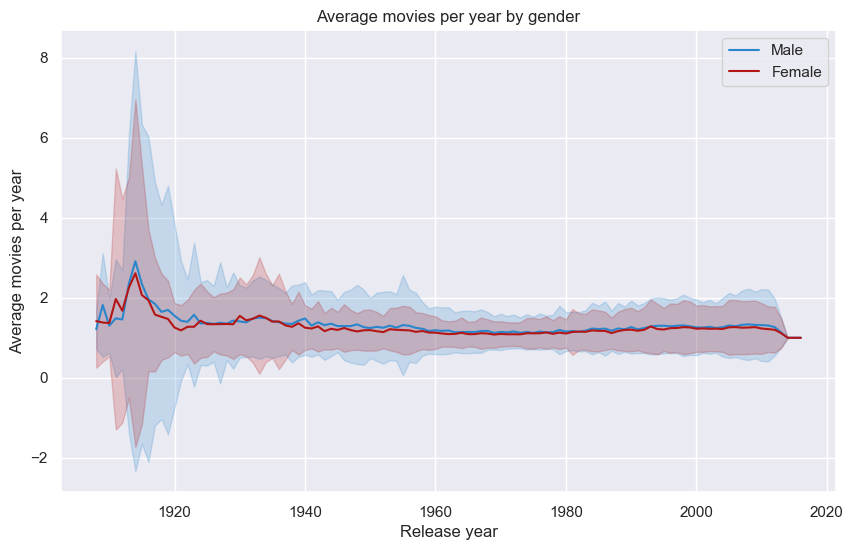

In [53]:
male_data = frequency_df[frequency_df['gender'] == 'M']
female_data = frequency_df[frequency_df['gender'] == 'F']

average_movie_count_male = male_data.groupby('release_date')['movie_count'].agg(['mean', 'std']).reset_index()
average_movie_count_male = average_movie_count_male[average_movie_count_male['release_date'] >= 1908]

average_movie_count_female = female_data.groupby('release_date')['movie_count'].agg(['mean', 'std']).reset_index()
average_movie_count_female = average_movie_count_female[average_movie_count_female['release_date'] >= 1908]

plt.figure(figsize=(10, 6))
sns.lineplot(data=average_movie_count_male, x='release_date', y='mean', label='Male', color = '#2986cc')
plt.fill_between(average_movie_count_male['release_date'], 
                 average_movie_count_male['mean'] - average_movie_count_male['std'],
                 average_movie_count_male['mean'] + average_movie_count_male['std'],
                 alpha=0.2, color = '#2986cc')

sns.lineplot(data=average_movie_count_female, x='release_date', y='mean', label='Female', color='#b41515')
plt.fill_between(average_movie_count_female['release_date'], 
                 average_movie_count_female['mean'] - average_movie_count_female['std'],
                 average_movie_count_female['mean'] + average_movie_count_female['std'],
                 alpha=0.2, color='#b41515')

plt.xlabel('Release year')
plt.ylabel('Average movies per year')
plt.title('Average movies per year by gender')
plt.legend()
plt.grid(True)
plt.show()

**Frequency by region**

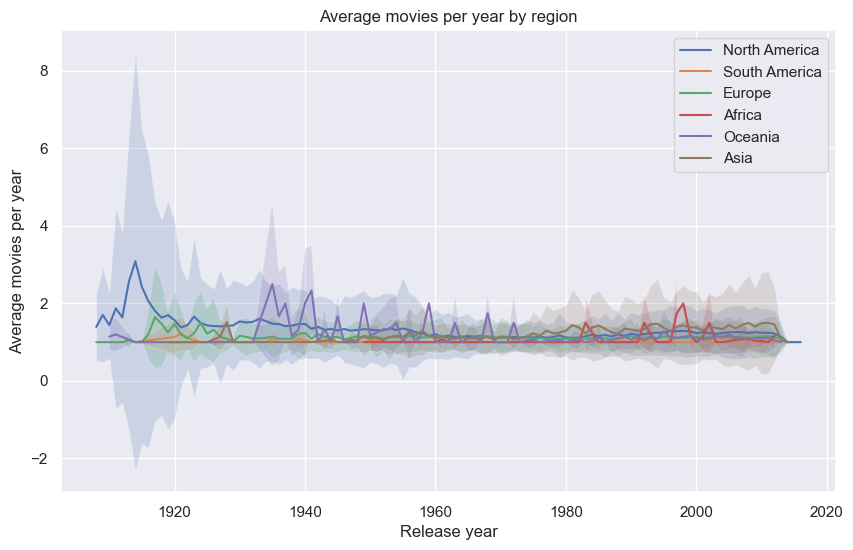

In [55]:
NA_data = frequency_df[frequency_df['region'] == 'North America']
SA_data = frequency_df[frequency_df['region'] == 'South America']
EU_data = frequency_df[frequency_df['region'] == 'Europe']
AF_data = frequency_df[frequency_df['region'] == 'Africa']
OC_data = frequency_df[frequency_df['region'] == 'Oceania']
AS_data = frequency_df[frequency_df['region'] == 'Asia']

average_movie_count_NA = NA_data.groupby('release_date')['movie_count'].agg(['mean', 'std']).reset_index()
average_movie_count_NA = average_movie_count_NA[average_movie_count_NA['release_date'] >= 1908]

average_movie_count_SA = SA_data.groupby('release_date')['movie_count'].agg(['mean', 'std']).reset_index()
average_movie_count_SA = average_movie_count_SA[average_movie_count_SA['release_date'] >= 1908]

average_movie_count_EU = EU_data.groupby('release_date')['movie_count'].agg(['mean', 'std']).reset_index()
average_movie_count_EU = average_movie_count_EU[average_movie_count_EU['release_date'] >= 1908]

average_movie_count_AF = AF_data.groupby('release_date')['movie_count'].agg(['mean', 'std']).reset_index()
average_movie_count_AF = average_movie_count_AF[average_movie_count_AF['release_date'] >= 1908]

average_movie_count_OC = OC_data.groupby('release_date')['movie_count'].agg(['mean', 'std']).reset_index()
average_movie_count_OC = average_movie_count_OC[average_movie_count_OC['release_date'] >= 1908]

average_movie_count_AS = AS_data.groupby('release_date')['movie_count'].agg(['mean', 'std']).reset_index()
average_movie_count_AS = average_movie_count_AS[average_movie_count_AS['release_date'] >= 1908]


plt.figure(figsize=(10, 6))
sns.lineplot(data=average_movie_count_NA, x='release_date', y='mean', label='North America')
plt.fill_between(average_movie_count_NA['release_date'], 
                 average_movie_count_NA['mean'] - average_movie_count_NA['std'],
                 average_movie_count_NA['mean'] + average_movie_count_NA['std'],
                 alpha=0.2)

sns.lineplot(data=average_movie_count_SA, x='release_date', y='mean', label='South America')
plt.fill_between(average_movie_count_SA['release_date'], 
                 average_movie_count_SA['mean'] - average_movie_count_SA['std'],
                 average_movie_count_SA['mean'] + average_movie_count_SA['std'],
                 alpha=0.2)

sns.lineplot(data=average_movie_count_EU, x='release_date', y='mean', label='Europe')
plt.fill_between(average_movie_count_EU['release_date'], 
                 average_movie_count_EU['mean'] - average_movie_count_EU['std'],
                 average_movie_count_EU['mean'] + average_movie_count_EU['std'],
                 alpha=0.2)

sns.lineplot(data=average_movie_count_AF, x='release_date', y='mean', label='Africa')
plt.fill_between(average_movie_count_AF['release_date'], 
                 average_movie_count_AF['mean'] - average_movie_count_AF['std'],
                 average_movie_count_AF['mean'] + average_movie_count_AF['std'],
                 alpha=0.2)

sns.lineplot(data=average_movie_count_OC, x='release_date', y='mean', label='Oceania')
plt.fill_between(average_movie_count_OC['release_date'], 
                 average_movie_count_OC['mean'] - average_movie_count_OC['std'],
                 average_movie_count_OC['mean'] + average_movie_count_OC['std'],
                 alpha=0.2)

sns.lineplot(data=average_movie_count_AS, x='release_date', y='mean', label='Asia')
plt.fill_between(average_movie_count_AS['release_date'], 
                 average_movie_count_AS['mean'] - average_movie_count_AS['std'],
                 average_movie_count_AS['mean'] + average_movie_count_AS['std'],
                 alpha=0.2)

plt.xlabel('Release year')
plt.ylabel('Average movies per year')
plt.title('Average movies per year by region')
plt.legend()
plt.grid(True)
plt.show()

We can see that even if the mean frequency remains constant over time (with a peak in the 1910s in the US as seen before) and that there are not a lot of differences between men and women, considering the datas over time highlights different trends over time (the American moguls in 1910s, the emergence of Asian movie since the 1970 which corresponds to Bollywood golden era : https://www.nfi.edu/what-is-bollywood/#:~:text=Bollywood%2C%20often%20known%20as%20the,around%201000%20films%20every%20year.).

### Career span of actors

While some actors gain fame by appearing in numerous movies within a short timeframe, others achieve recognition due to their everlasting careers. Our focus now is to examine the career spans of each actor, taking into account their first and last appearances in the provided dataset.

Our analysis will delve into regional and gender differences, with a look at mid-career age (where available) to assess whether commencing a career at a young age holds significance in an actor's trajectory.

**Career span of actors by gender**

Mean career span for male actors: 13.08 years (+/-  11.21) 
Mean career span for female actors: 11.38 years (+/- 10.74) 


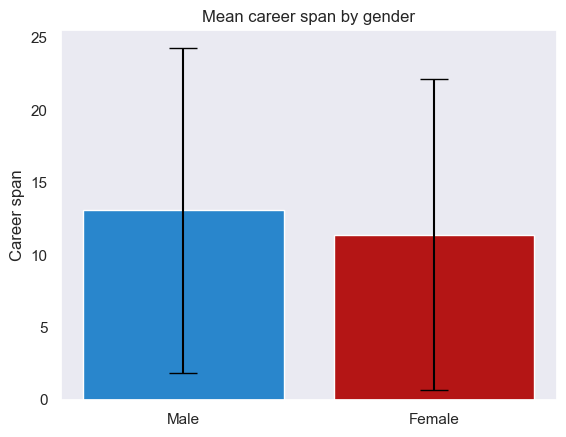

In [57]:
character_df['release_date'] = pd.to_datetime(character_df['release_date'], errors='coerce')

actor_career_span = character_df.groupby('actor_name')['release_date'].agg(['min', 'max']).reset_index()
actor_career_span['career_span'] = (actor_career_span['max'] - actor_career_span['min']).dt.days / 365

# Avoid anomalies due to missing values
span_thresh = 50  
actor_career_span = actor_career_span[(actor_career_span['career_span'] != 0) & (actor_career_span['career_span'] < span_thresh)]

actor_career_span = actor_career_span.merge(character_df[['actor_name', 'actor_age_at_movie_release', 'gender']], on='actor_name', how='inner')
actor_career_span['mid_career_age'] = (actor_career_span['actor_age_at_movie_release'] + actor_career_span['career_span']) / 2
actor_career_span = actor_career_span.rename(columns={"actor_age_at_movie_release": "age at last movie"})

actor_career_span = actor_career_span.merge(count_char_df[['actor_name', 'region']], on='actor_name', how='inner')
actor_career_span = actor_career_span.drop_duplicates(subset=['actor_name', 'career_span', 'gender'])

# Gender analysis 
male_actors = actor_career_span[actor_career_span['gender'] == 'M']
female_actors = actor_career_span[actor_career_span['gender'] == 'F']

mean_career_span_male = male_actors['career_span'].mean()
std_career_span_male = male_actors['career_span'].std()
mean_career_span_female = female_actors['career_span'].mean()
std_career_span_female = female_actors['career_span'].std()

print(f"Mean career span for male actors: {mean_career_span_male:.2f} years (+/-  {std_career_span_male:.2f}) ")
print(f"Mean career span for female actors: {mean_career_span_female:.2f} years (+/- {std_career_span_female:.2f}) ")

labels = ['Male', 'Female']
bar_colors = ['#2986cc', '#b41515']

x_pos = range(len(labels))
plt.bar(x_pos, [mean_career_span_male, mean_career_span_female],
        yerr=[std_career_span_male, std_career_span_female],
        align='center', ecolor='black', capsize=10, color=bar_colors)
plt.xticks(x_pos, labels)
plt.ylabel('Career span')
plt.title('Mean career span by gender')
plt.grid()
plt.show()

This is a relatively high variance, so we can not assess anything about the career span of male or female yet. Let's try to do a t-test :

If the p-value is inferior to 0.05, we could assess that there is strong evidence about the difference between male and female actors.

In [58]:
from scipy.stats import ttest_ind

t_statistic, p_value = ttest_ind(male_actors['career_span'], female_actors['career_span'])

print(f"t-statistic: {t_statistic:.2f}, p-value: {p_value:.4f}")

t-statistic: 13.15, p-value: 0.0000


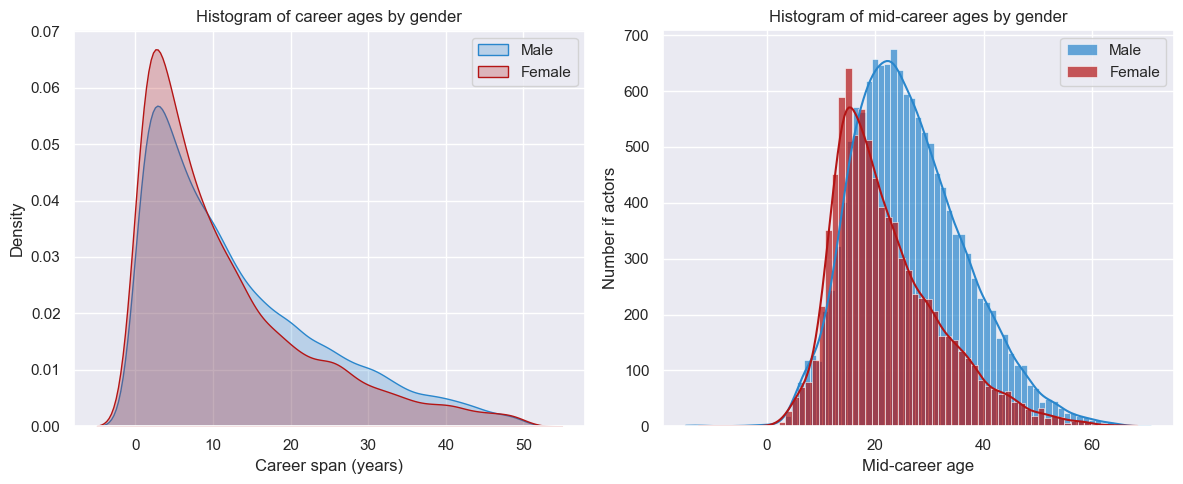

In [61]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.kdeplot(male_actors['career_span'], label='Male', shade=True, color='#2986cc', ax=axs[0])
sns.kdeplot(female_actors['career_span'], label='Female', shade=True, color='#b41515', ax=axs[0])
axs[0].set_xlabel('Career span (years)')
axs[0].set_ylabel('Density')
axs[0].set_title('Histogram of career ages by gender')
axs[0].legend()
axs[0].grid(True)

male_mid_career = actor_career_span[actor_career_span['gender'] == 'M']['mid_career_age']
female_mid_career = actor_career_span[actor_career_span['gender'] == 'F']['mid_career_age']

sns.histplot(male_mid_career, kde=True, label='Male', color='#2986cc', alpha=0.7, ax=axs[1])
sns.histplot(female_mid_career, kde=True, label='Female', color='#b41515', alpha=0.7, ax=axs[1])

axs[1].set_xlabel('Mid-career age')
axs[1].set_ylabel('Number if actors')
axs[1].set_title('Histogram of mid-career ages by gender')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

**Career span of actors by region**

Mean career span for North America actors: 12.47 years (+/-  10.98) 
Mean career span for South America actors: 10.59 years (+/- 10.28) 
Mean career span for Europe actors: 12.62 years (+/-  11.56) 
Mean career span for Asia actors: 11.23 years (+/- 10.66) 
Mean career span for Africa actors: 8.40 years (+/-  8.84) 
Mean career span for Oceania actors: 11.45 years (+/- 10.44) 


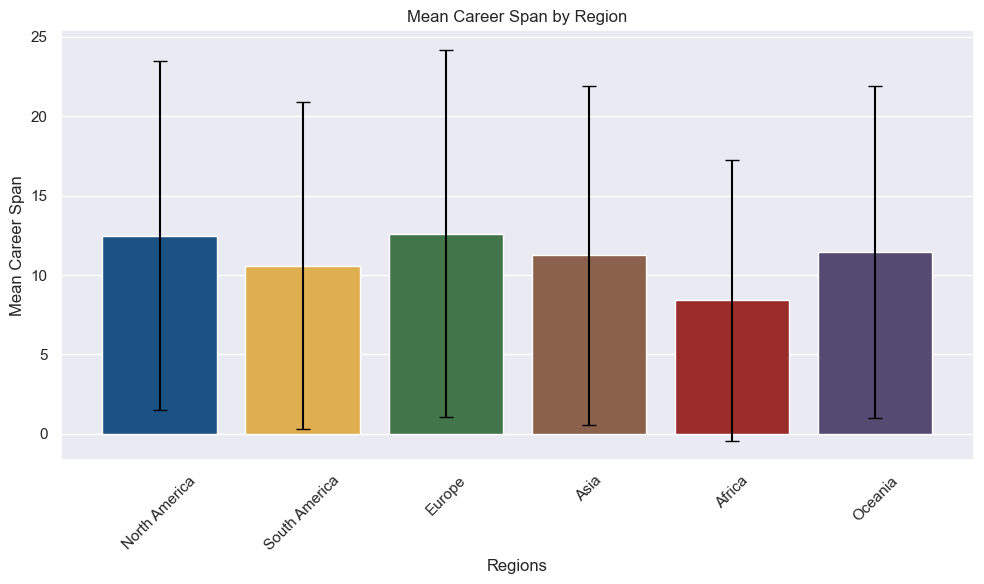

In [63]:
NA_actors = actor_career_span[actor_career_span['region'] == 'North America']
SA_actors = actor_career_span[actor_career_span['region'] == 'South America']
EU_actors = actor_career_span[actor_career_span['region'] == 'Europe']
AS_actors = actor_career_span[actor_career_span['region'] == 'Asia']
AF_actors = actor_career_span[actor_career_span['region'] == 'Africa']
OC_actors = actor_career_span[actor_career_span['region'] == 'Oceania']

mean_career_span_NA = NA_actors['career_span'].mean()
std_career_span_NA = NA_actors['career_span'].std()
mean_career_span_SA = SA_actors['career_span'].mean()
std_career_span_SA = SA_actors['career_span'].std()
mean_career_span_EU = EU_actors['career_span'].mean()
std_career_span_EU = EU_actors['career_span'].std()
mean_career_span_AS = AS_actors['career_span'].mean()
std_career_span_AS = AS_actors['career_span'].std()
mean_career_span_AF = AF_actors['career_span'].mean()
std_career_span_AF = AF_actors['career_span'].std()
mean_career_span_OC = OC_actors['career_span'].mean()
std_career_span_OC = OC_actors['career_span'].std()

print(f"Mean career span for North America actors: {mean_career_span_NA:.2f} years (+/-  {std_career_span_NA:.2f}) ")
print(f"Mean career span for South America actors: {mean_career_span_SA:.2f} years (+/- {std_career_span_SA:.2f}) ")
print(f"Mean career span for Europe actors: {mean_career_span_EU:.2f} years (+/-  {std_career_span_EU:.2f}) ")
print(f"Mean career span for Asia actors: {mean_career_span_AS:.2f} years (+/- {std_career_span_AS:.2f}) ")
print(f"Mean career span for Africa actors: {mean_career_span_AF:.2f} years (+/-  {std_career_span_AF:.2f}) ")
print(f"Mean career span for Oceania actors: {mean_career_span_OC:.2f} years (+/- {std_career_span_OC:.2f}) ")

regions = ['North America', 'South America', 'Europe', 'Asia', 'Africa', 'Oceania']
mean_career_spans = [mean_career_span_NA, mean_career_span_SA, mean_career_span_EU, mean_career_span_AS, mean_career_span_AF, mean_career_span_OC]
std_career_spans = [std_career_span_NA, std_career_span_SA, std_career_span_EU, std_career_span_AS, std_career_span_AF, std_career_span_OC]

colors = ['#0b5394', '#f7b538', '#3a7d44', '#955e42', '#ac1a1a', '#524379']

plt.figure(figsize=(10, 6))

sns.barplot(x=regions, y=mean_career_spans, palette=colors, errorbar='sd')
plt.errorbar(x=regions, y=mean_career_spans, yerr=std_career_spans, fmt='none', ecolor='black', capsize=5)

plt.xlabel('Regions')
plt.ylabel('Mean Career Span')
plt.title('Mean Career Span by Region')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

It is interesting to see that in Europe and North America, actors seem to have a greater career span than others. Let's look at their respective mid career age and density :

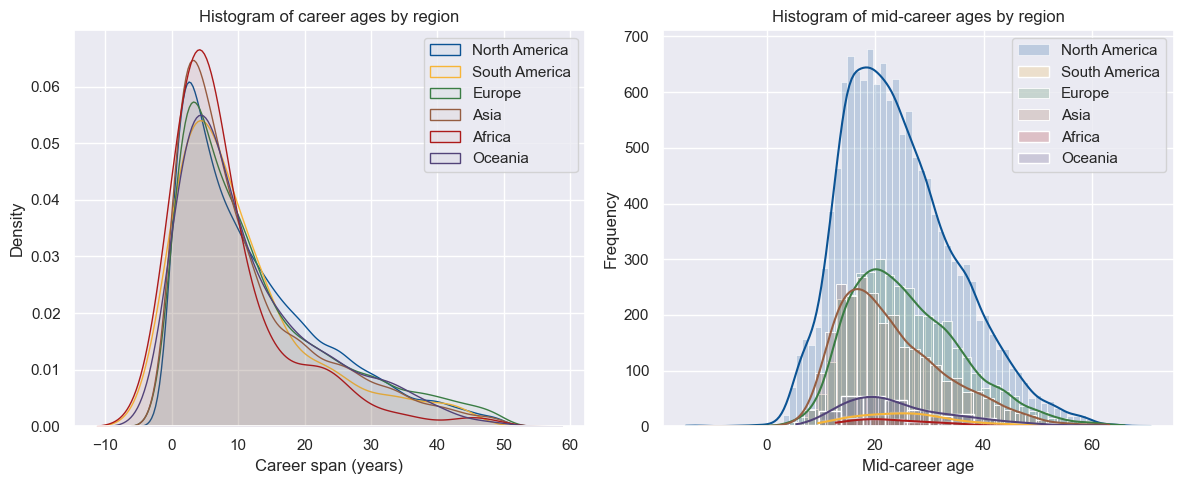

In [64]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.kdeplot(NA_actors['career_span'], label='North America', shade=True, color='#0b5394', alpha=0.05, ax=axs[0])
sns.kdeplot(SA_actors['career_span'], label='South America', shade=True, color='#f7b538', alpha=0.05, ax=axs[0])
sns.kdeplot(EU_actors['career_span'], label='Europe', shade=True, color='#3a7d44', alpha=0.05, ax=axs[0])
sns.kdeplot(AS_actors['career_span'], label='Asia', shade=True, color='#955e42', alpha=0.05, ax=axs[0])
sns.kdeplot(AF_actors['career_span'], label='Africa', shade=True, color='#ac1a1a', alpha=0.05, ax=axs[0])
sns.kdeplot(OC_actors['career_span'], label='Oceania', shade=True, color='#524379', alpha=0.05, ax=axs[0])

axs[0].set_xlabel('Career span (years)')
axs[0].set_ylabel('Density')
axs[0].set_title('Histogram of career ages by region')
axs[0].legend()
axs[0].grid(True)

NA_mid_career = actor_career_span[actor_career_span['region'] == 'North America']['mid_career_age']
SA_mid_career = actor_career_span[actor_career_span['region'] == 'South America']['mid_career_age']
EU_mid_career = actor_career_span[actor_career_span['region'] == 'Europe']['mid_career_age']
AS_mid_career = actor_career_span[actor_career_span['region'] == 'Asia']['mid_career_age']
AF_mid_career = actor_career_span[actor_career_span['region'] == 'Africa']['mid_career_age']
OC_mid_career = actor_career_span[actor_career_span['region'] == 'Oceania']['mid_career_age']

sns.histplot(NA_mid_career, kde=True, label='North America', color='#0b5394', alpha=0.2, ax=axs[1])
sns.histplot(SA_mid_career, kde=True, label='South America', color='#f7b538', alpha=0.2, ax=axs[1])
sns.histplot(EU_mid_career, kde=True, label='Europe', color='#3a7d44', alpha=0.2, ax=axs[1])
sns.histplot(AS_mid_career, kde=True, label='Asia', color='#955e42', alpha=0.2, ax=axs[1])
sns.histplot(AF_mid_career, kde=True, label='Africa', color='#ac1a1a', alpha=0.2, ax=axs[1])
sns.histplot(OC_mid_career, kde=True, label='Oceania', color='#524379', alpha=0.2, ax=axs[1])

axs[1].set_xlabel('Mid-career age')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Histogram of mid-career ages by region')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

The analysis reveals that actors in South America and Europe tend to have a higher mid-career age compared to those in other regions, while those in Asia and Oceania exhibit a lower mid-career age. Although the dataset for Africa is limited, it suggests a trend toward shorter career spans, whereas the distribution in other regions appears more varied and diverse. In the second plot, it's crucial to note that no actors have a negative career span, despite an apparent error that comes from the Kernel Density Estimator (KDE) utilized for the plot.

### Number of movies per actor

Finally, despite the insights we got from the combined analyses of frequency and career span, it's crucial to consider the total number of movies an actor has made throughout their career. This step is essential due to potential missing values in the initial dataset and the impact that career breaks might have on reducing the mean frequency.

This forthcoming analysis will specifically concentrate on the density of movies produced, by gender and region. By examining movie density across these parameters, we aim to gain a more comprehensive understanding on the measuring of success.

**General analysis**

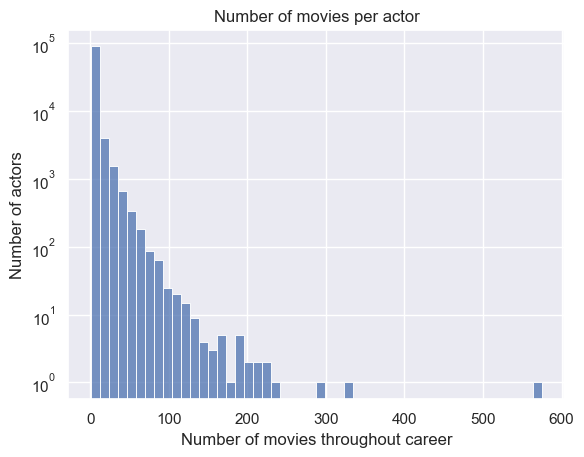

                actor_name gender  total_movie_count         region
254905           Mel Blanc      M                575  North America
267366  Mithun Chakraborty      M                328          Other
284085        Oliver Hardy      M                299  North America
268496            Mohanlal      M                234           Asia
237509           Mammootty      M                225          Other


In [66]:
actor_nb_movie = character_df.groupby(['actor_name', 'gender', 'movie_id']).size().reset_index(name='appearance_count')
actor_nb_movie = actor_nb_movie.groupby(['actor_name', 'gender']).size().reset_index(name='total_movie_count')
actor_nb_movie = actor_nb_movie.merge(count_char_df[['actor_name', 'region']], on='actor_name', how='inner')
actor_nb_movie = actor_nb_movie.drop_duplicates(subset=['actor_name'])


sns.histplot(actor_nb_movie, x='total_movie_count', bins=50, log=True)
plt.ylabel("Number of actors")
plt.xlabel("Number of movies throughout career")
plt.title("Number of movies per actor")
plt.show()

sorted_actors = actor_nb_movie.sort_values(by='total_movie_count', ascending=False) 
top_5_actors_corrected = sorted_actors.head(5)
print(top_5_actors_corrected)

The top 5 is mainly composed of mens, let's try to compare with women. In fact, we may have to consider productions locally, because the leaderboard is exclusively from America in the early ages of cinema and from India now-a-days, for example.

**Number of movies by gender**

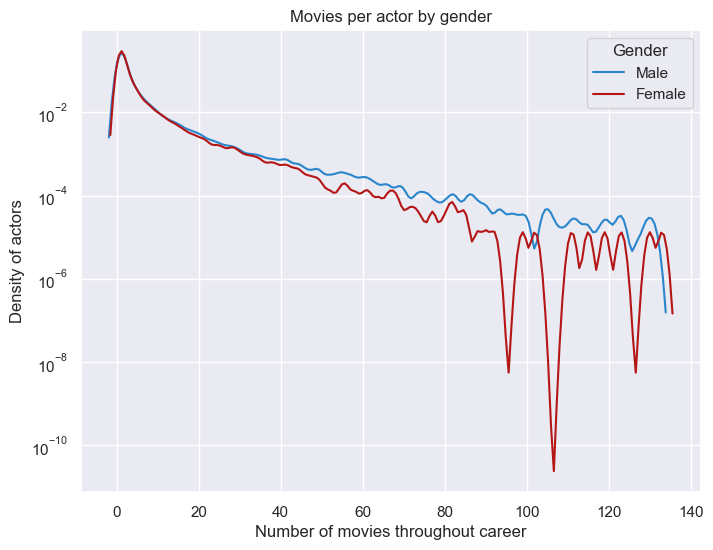

In [67]:
male_data = actor_nb_movie[actor_nb_movie['gender'] == 'M']
female_data = actor_nb_movie[actor_nb_movie['gender'] == 'F']

# The max number of movies for women are 133 so we filter values above to compare
male_filtered = male_data[male_data['total_movie_count'] <= 133]
female_filtered = female_data[female_data['total_movie_count'] <= 133]

plt.figure(figsize=(8, 6))
sns.kdeplot(data=male_filtered['total_movie_count'], label='Male', color = '#2986cc')
sns.kdeplot(data=female_filtered['total_movie_count'], label='Female', color = '#b41515')

plt.yscale('log')
plt.ylabel("Density of actors")
plt.xlabel("Number of movies throughout career")
plt.title("Movies per actor by gender")
plt.legend(title='Gender')
plt.show()

There are noticeable disparities between males and females in terms of the number of movies made (we applied a threshold to the male dataset for a clearer plot), with males generally being more numerous and having a higher overall number of movies. However, despite these differences, both genders exhibit a similar distribution pattern in terms of movie density.

It is also crucial to highlight that the 'V' gaps in the plot result from missing values at specific movie counts — there are no actors with that exact number of movies.

**Number of movies per region**

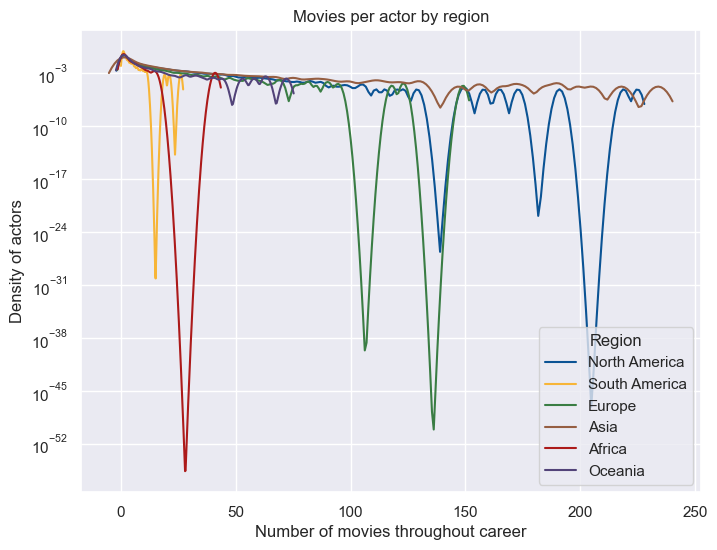

In [69]:
NA_films = actor_nb_movie[actor_nb_movie['region'] == 'North America']
SA_films = actor_nb_movie[actor_nb_movie['region'] == 'South America']
EU_films = actor_nb_movie[actor_nb_movie['region'] == 'Europe']
AS_films = actor_nb_movie[actor_nb_movie['region'] == 'Asia']
AF_films = actor_nb_movie[actor_nb_movie['region'] == 'Africa']
OC_films = actor_nb_movie[actor_nb_movie['region'] == 'Oceania']

# Filtering here too for clarity (North America goes all over to 500)
NA_films_filtered = NA_films[NA_films['total_movie_count'] <= 250]
SA_films_filtered = SA_films[SA_films['total_movie_count'] <= 250]
EU_films_filtered = EU_films[EU_films['total_movie_count'] <= 250]
AS_films_filtered = AS_films[AS_films['total_movie_count'] <= 250]
AF_films_filtered = AF_films[AF_films['total_movie_count'] <= 250]
OC_films_filtered = OC_films[OC_films['total_movie_count'] <= 250]

plt.figure(figsize=(8, 6))
sns.kdeplot(data=NA_films_filtered['total_movie_count'], label='North America', color = '#0b5394')
sns.kdeplot(data=SA_films_filtered['total_movie_count'], label='South America', color = '#f7b538')
sns.kdeplot(data=EU_films_filtered['total_movie_count'], label='Europe', color = '#3a7d44')
sns.kdeplot(data=AS_films_filtered['total_movie_count'], label='Asia', color = '#955e42')
sns.kdeplot(data=AF_films_filtered['total_movie_count'], label='Africa', color = '#ac1a1a')
sns.kdeplot(data=OC_films_filtered['total_movie_count'], label='Oceania', color = '#524379')

plt.yscale('log') 

plt.ylabel("Density of actors")
plt.xlabel("Number of movies throughout career")
plt.title("Movies per actor by region")
plt.legend(title='Region')

plt.show()

Regionally, glaring disparities in distribution are noticeable. In particular, North America and Asia stand out as the only regions where a few actors have more than 200 movie appearances. In contrary, South America, Africa, and Oceania demonstrate significantly fewer actors with numerous movie appearances.

### Combining all three factors for longevity

To have a comprehensive longevity score, our approach involves mixing the insights obtained from the three analyses conducted earlier. We tried to synthesize these findings by firstly generate a pairplot to visualize relationships between the variables studied across frequency, career span, and number of movies. Then, we aim to construct a distribution of scores that harmonizes these diverse aspects, allowing us to create a meaningful evaluation.

**Pairplot**

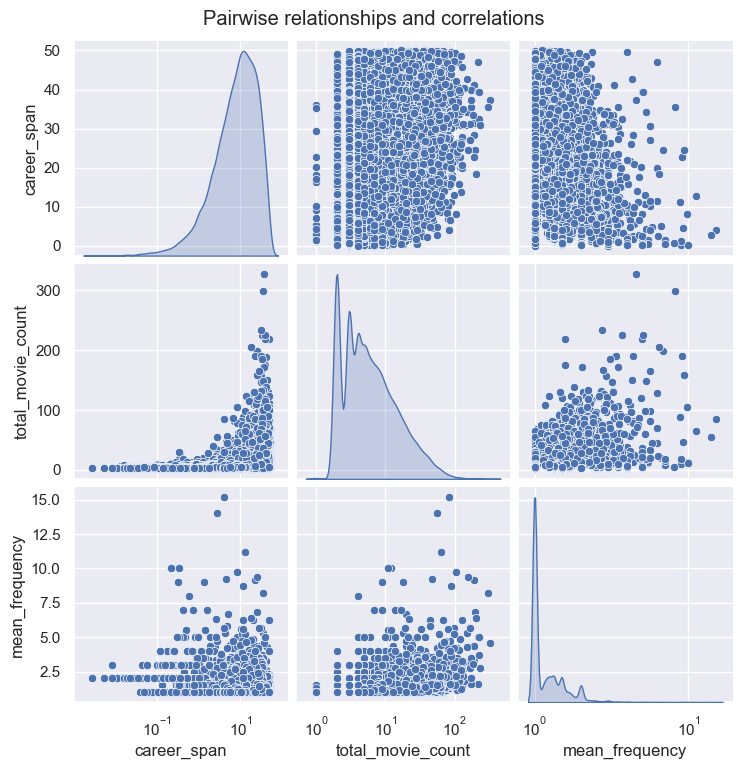

In [73]:
freq_span_nbmv = pd.merge(mean_frequency, actor_career_span, on=['actor_name', 'gender', 'region'])
freq_span_nbmv = pd.merge(freq_span_nbmv, actor_nb_movie, on=['actor_name', 'gender', 'region'])
freq_span_nbmv.dropna(subset=['career_span', 'total_movie_count', 'mean_frequency'], inplace=True)

data_pairplot = freq_span_nbmv[['career_span', 'total_movie_count', 'mean_frequency']]

sns.pairplot(data_pairplot, diag_kind='kde', diag_kws={'log_scale': 10})
plt.suptitle('Pairwise relationships and correlations', y=1.02)
plt.show()

The pairplot effectively reveals interdependencies among the three attributes. In fact, it reveals causal relationships: higher career span tends to correlate with higher total movie count, although the reverse isn't necessarily true. Moreover, there appears to be a positive correlation between frequency and both the number of movies and career span.

**Final score for longevity**

The final longevity score is derived from a combination of the three attributes. Initially, we normalized the data to ensure fairness across attributes, subsequently rescaling it to fit within a 0 to 10 range. Employing the Box-Cox transform helped rectify skewed distributions into Gaussian ones. Finally, the outcomes were spread using a uniform distribution to secure scores between 0 and 10, with an approximate mean of 5 and a standard deviation of about 1.

We obtained the following distributions throughout our process : 

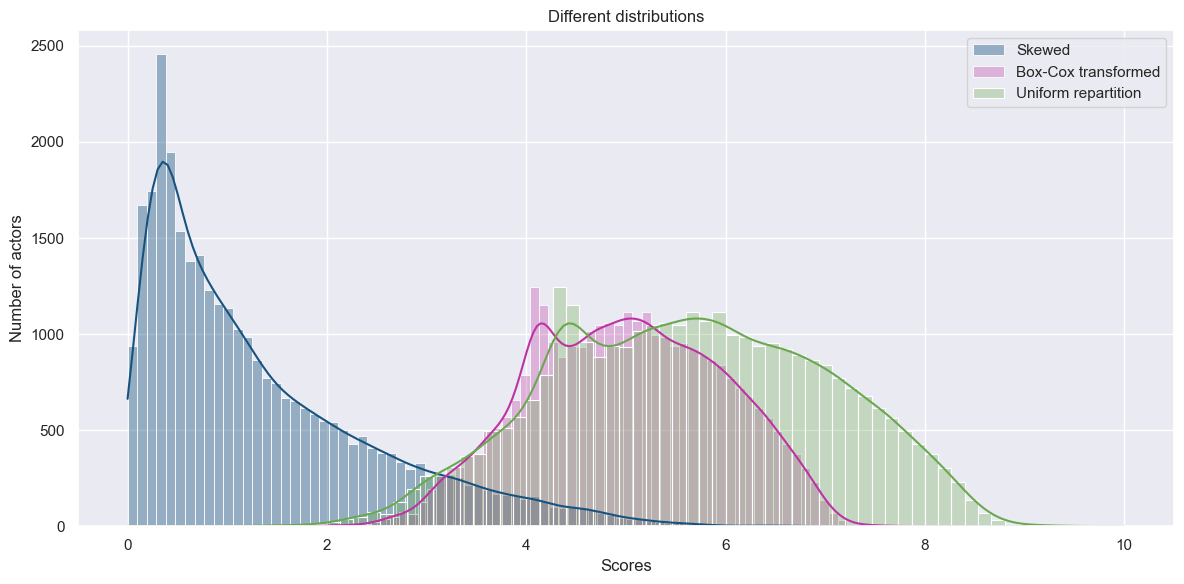

count    31624.000000
mean         5.639477
std          1.373878
min          0.000000
25%          4.574634
50%          5.638891
75%          6.687040
max         10.000000
Name: longv_score, dtype: float64

In [87]:
normalized_data = (freq_span_nbmv[['mean_frequency', 'career_span', 'total_movie_count']] - freq_span_nbmv[['mean_frequency', 'career_span', 'total_movie_count']].min()) / (freq_span_nbmv[['mean_frequency', 'career_span', 'total_movie_count']].max() - freq_span_nbmv[['mean_frequency', 'career_span', 'total_movie_count']].min())

weights = {'mean_frequency': 0.33333, 'career_span': 0.33333, 'total_movie_count': 0.3333}
weighted_score = (normalized_data['mean_frequency'] * weights['mean_frequency']) + (normalized_data['career_span'] * weights['career_span']) + (normalized_data['total_movie_count'] * weights['total_movie_count'])

rescaled_score = (weighted_score - weighted_score.min()) / (weighted_score.max() - weighted_score.min()) * 10 + 0.00001
freq_span_nbmv['longv_score'] = rescaled_score

# Box-Cox transformation
transformed_scores, lambda_value = stats.boxcox(rescaled_score)
mean_of_transformed_scores = np.mean(transformed_scores)

factor = 5 - mean_of_transformed_scores
adjusted_scores = transformed_scores + factor

min_score = np.min(adjusted_scores)
max_score = np.max(adjusted_scores)

scaled_scores = ((adjusted_scores - min_score) / (max_score - min_score)) * 10

plt.figure(figsize=(12, 6))

sns.histplot(rescaled_score, kde=True, color = '#16537e', label = 'Skewed', alpha = 0.4)
sns.histplot(adjusted_scores, kde=True, color = '#bd33a4', label = 'Box-Cox transformed', alpha = 0.3)
sns.histplot(scaled_scores, kde=True, color = '#6aa84f', label = 'Uniform repartition', alpha = 0.3)

plt.xlabel('Scores')
plt.ylabel('Number of actors')
plt.title('Different distributions')

plt.legend()
plt.tight_layout()
plt.show()

freq_span_nbmv['longv_score'] = scaled_scores
freq_span_nbmv['longv_score'].describe()

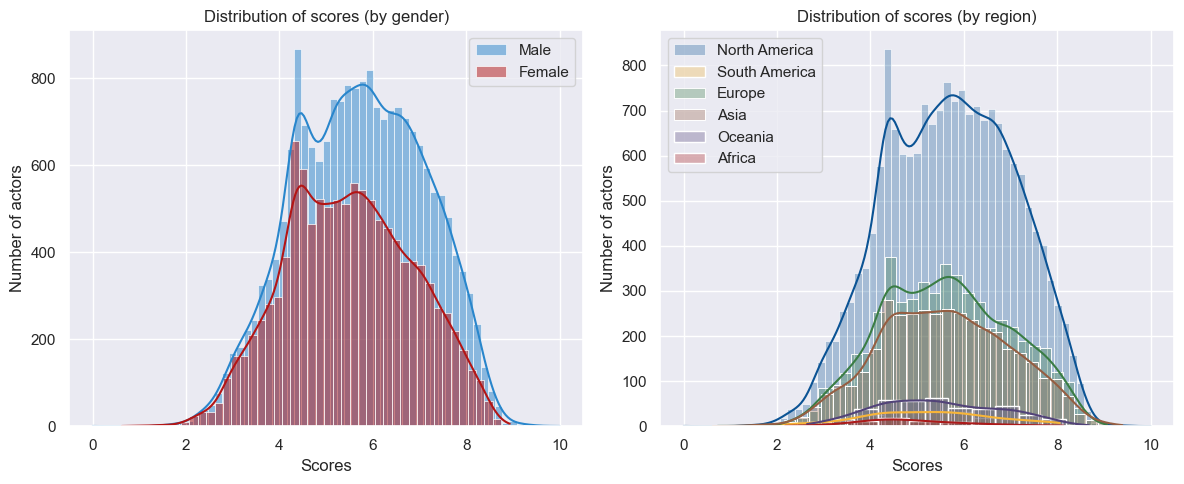

In [88]:
male_freq_span_nbmv = freq_span_nbmv[freq_span_nbmv['gender'] == 'M']
female_freq_span_nbmv = freq_span_nbmv[freq_span_nbmv['gender'] == 'F']

NA_freq_span_nbmv = freq_span_nbmv[freq_span_nbmv['region'] == 'North America']
SA_freq_span_nbmv = freq_span_nbmv[freq_span_nbmv['region'] == 'South America']
EU_freq_span_nbmv = freq_span_nbmv[freq_span_nbmv['region'] == 'Europe']
AS_freq_span_nbmv = freq_span_nbmv[freq_span_nbmv['region'] == 'Asia']
OC_freq_span_nbmv = freq_span_nbmv[freq_span_nbmv['region'] == 'Oceania']
AF_freq_span_nbmv = freq_span_nbmv[freq_span_nbmv['region'] == 'Africa']


fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(male_freq_span_nbmv['longv_score'], kde=True, label='Male',color='#2986cc', ax=axs[0])
sns.histplot(female_freq_span_nbmv['longv_score'], kde=True, label='Female',color='#b41515', ax=axs[0])
axs[0].set_xlabel('Scores')
axs[0].set_ylabel('Number of actors')
axs[0].set_title('Distribution of scores (by gender)')
axs[0].legend()
axs[0].grid(True)


sns.histplot(NA_freq_span_nbmv['longv_score'], kde=True, label='North America',color='#0b5394', alpha = 0.3, ax=axs[1])
sns.histplot(SA_freq_span_nbmv['longv_score'], kde=True, label='South America',color='#f7b538', alpha = 0.3, ax=axs[1])
sns.histplot(EU_freq_span_nbmv['longv_score'], kde=True, label='Europe',color='#3a7d44', alpha = 0.3, ax=axs[1])
sns.histplot(AS_freq_span_nbmv['longv_score'], kde=True, label='Asia',color='#955e42', alpha = 0.3, ax=axs[1])
sns.histplot(OC_freq_span_nbmv['longv_score'], kde=True, label='Oceania',color='#524379', alpha = 0.3, ax=axs[1])
sns.histplot(AF_freq_span_nbmv['longv_score'], kde=True, label='Africa',color='#ac1a1a', alpha = 0.3, ax=axs[1])

axs[1].set_xlabel('Scores')
axs[1].set_ylabel('Number of actors')
axs[1].set_title('Distribution of scores (by region)')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
The scores are equally distributed between men and women, considering there are fewer women in the provided dataset. Nonethele

In [89]:
top_actors = freq_span_nbmv.sort_values(by='longv_score', ascending=False)
top_actors.head(10)

,actor_name,mean_frequency,gender,region,min,max,career_span,age at last movie,mid_career_age,total_movie_count,weighted_score,longv_score
22485,Oliver Hardy,8.187500,M,North America,1914-04-21,1949-09-15,35.427397,NaN,NaN,299,10.000000,10.000000
21217,Mithun Chakraborty,4.567568,M,Other,1976-01-01,2013-05-15,37.394521,44.0,40.697260,328,9.850422,9.850422
21249,Moe Howard,5.030303,M,North America,1930-09-28,1970-02-05,39.383562,NaN,NaN,225,9.542929,9.542929
17141,Larry Fine,5.000000,M,North America,1930-09-28,1970-02-05,39.383562,55.0,47.191781,219,9.515507,9.515507
7017,Dharmendra Deol,1.586207,M,Asia,1964-10-08,2011-10-27,47.082192,75.0,61.041096,218,9.392710,9.392710
10959,Harold Lloyd,9.150000,M,North America,1913-05-08,1936-02-07,22.767123,NaN,NaN,191,9.341495,9.341495
1138,Amitabh Bachchan,3.297297,M,Asia,1972-02-23,2013-05-10,41.238356,NaN,NaN,189,9.271122,9.271122
25781,Roscoe Arbuckle,9.375000,M,North America,1909-07-01,1933-12-30,24.515068,NaN,NaN,158,9.269243,9.269243
9316,Frank Welker,4.323529,M,North America,1969-12-31,2012-10-09,42.802740,30.0,36.401370,150,9.248137,9.248137
18820,Mammootty,3.714286,M,Other,1980-05-16,2012-10-19,32.449315,43.0,37.724658,225,9.217608,9.217608


## 3.b. Revenues

### Preparing the dataset

Here, we are looking at an aggregate outcome throughout one's career. Contrary to the previous analysis, we want to associate here an amount to characteristics that are fixed over an actor's career. Someone's age on the movie release date no longer matters, but their career start date might. Gender and height are still relevant. For movie characteristics, we can aggregate them over the career, selecting the largest occurence for instance.

Hence, we isolate the following variables that might explain cumulated movie revenues:
- Actor's age at the beginning of their career
- Actor's gender
- Mean age during the career
- Actor's ethnicity
- Actor's height
- Most frequent movie language
- Most frequent country of the movie
- Variety of movie genres
- (to add: variety of roles)

**Merge actors with their movies within the CMU Movie Corpus**

In [111]:
actors_movies = characters.merge(movies, on='Freebase movie ID', how='left') 

In [112]:
actors_movies.columns

Index(['Wikipedia movie ID_x', 'Freebase movie ID', 'Movie release date_x',
       'Character name', 'Actor date of birth', 'Actor gender', 'Actor height',
       'Actor ethnicity', 'Actor name', 'Actor age at movie release',
       'Freebase character/actor map ID', 'Freebase character ID',
       'Freebase actor ID', 'e.id', 'Wikipedia Movie id', 'Movie name_x',
       'charName', 'fullName', 'occurences', 'max', 'Persona',
       'Wikipedia movie ID_y', 'Movie name_y', 'Movie release date_y',
       'Movie box office revenue', 'Movie runtime', 'Movie languages',
       'Movie countries', 'Movie genres'],
      dtype='object')

**Aggregate variables of interest to have values valable for the entire career span**

In [113]:
# Revenues wrt median of the year

# Compute the median revenue for each year
actors_movies['Movie release date'] = pd.to_datetime(actors_movies['Movie release date_x'], format='mixed', errors='coerce')

actors_movies['Year'] = actors_movies['Movie release date'].dt.year
median_revenue_by_year = actors_movies.groupby('Year')['Movie box office revenue'].median().reset_index()

# Merge the median revenue back into the original DataFrame
actors_movies = pd.merge(actors_movies, median_revenue_by_year, on='Year', suffixes=('', '_median'))

# Calculate the revenue by actor and year with respect to the median
actors_movies['Relative_Revenue'] = actors_movies['Movie box office revenue'] / actors_movies['Movie box office revenue_median']

In [114]:
# Count non-missing values in 'Revenue' column by year
non_missing_count_by_year = actors_movies.groupby('Year')['Movie box office revenue'].count().reset_index()

# Rename the count column for clarity
non_missing_count_by_year = non_missing_count_by_year.rename(columns={'Movie box office revenue': 'Non_Missing_Revenues'})

print(non_missing_count_by_year) # some years have zero revenue information

       Year  Non_Missing_Revenues
0    1888.0                     0
1    1891.0                     0
2    1893.0                     0
3    1894.0                     0
4    1895.0                     0
..      ...                   ...
121  2012.0                  2061
122  2013.0                     0
123  2014.0                     0
124  2015.0                     0
125  2016.0                     0

[126 rows x 2 columns]


In [115]:
actors_movies['Movie release date_x'].notna().sum() # also some missing values for dates prevent to compute revenues as a share of the median that year

440659

In [116]:
actors_movies[['Relative_Revenue','Movie box office revenue']]

,Relative_Revenue,Movie box office revenue
0,0.414667,14010832.0
1,0.414667,14010832.0
2,0.414667,14010832.0
3,0.414667,14010832.0
4,0.414667,14010832.0
...,...,...
440654,NaN,NaN
440655,NaN,NaN
440656,NaN,NaN
440657,NaN,NaN


In [117]:
actors_revenues = actors_movies.groupby('Actor name')

# Aggregating the desired statistics
actor_statistics = actors_revenues.agg({
    'Relative_Revenue': lambda x: x.fillna(0).sum(),
    'Actor gender': helpers.most_frequent_occ,
    'Actor age at movie release': 'mean',
    'Actor ethnicity': helpers.most_frequent_occ,
    'Actor height': helpers.most_frequent_occ,
    'Movie languages': helpers.most_frequent_in_dictionary,
    'Movie countries': helpers.most_frequent_in_dictionary,
    'Movie genres': helpers.most_frequent_in_dictionary,
    'Movie name_x': 'nunique',
    'Persona': 'nunique'
}).reset_index()

In [118]:
# More statistics
age_begin_career = actors_revenues['Actor age at movie release'].min()
unique_countries = actors_revenues['Movie countries'].apply(helpers.count_unique)
unique_genres = actors_revenues['Movie genres'].apply(helpers.count_unique)
unique_languages = actors_revenues['Movie languages'].apply(helpers.count_unique)

# We need precise mapping because they have other columns in common with different values, resulting in NaN
actor_statistics['age_begin_career'] = actor_statistics['Actor name'].map(age_begin_career)
actor_statistics['unique_countries'] = actor_statistics['Actor name'].map(unique_countries)
actor_statistics['unique_genres'] = actor_statistics['Actor name'].map(unique_genres)
actor_statistics['unique_languages'] = actor_statistics['Actor name'].map(unique_languages)

In [119]:
# Renaming the columns for clarity
actor_statistics.columns = ['Actor name','total_revenues','gender','mean_age','ethnicity','height','most_freq_language','most_freq_country','most_freq_genre','unique_movies', 'unique_persona', 'age_begin_career','unique_countries','unique_genres','unique_languages'] 
                            
# Displaying the resulting DataFrame
display(actor_statistics)

,Actor name,total_revenues,gender,mean_age,ethnicity,height,most_freq_language,most_freq_country,most_freq_genre,unique_movies,unique_persona,age_begin_career,unique_countries,unique_genres,unique_languages
0,Cesarine Prinz\t,0.0,F,NaN,None,NaN,None,Netherlands,Comedy,0,0,NaN,1.0,2.0,NaN
1,Daniel Newman,0.0,M,22.000000,None,NaN,English Language,Canada,Drama,0,0,22.0,3.0,2.0,1.0
2,'Big Bill' Giddinger,0.0,M,NaN,None,NaN,English Language,United States of America,History,0,0,NaN,1.0,5.0,1.0
3,'Big' Lee,0.0,M,NaN,None,NaN,English Language,United States of America,Crime Fiction,0,0,NaN,1.0,3.0,1.0
4,'Chicken' Holleman,0.0,None,NaN,None,NaN,English Language,United States of America,Crime Fiction,0,0,NaN,1.0,7.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133617,雅-miyavi-,0.0,M,22.000000,None,1.85,Japanese Language,Japan,Drama,0,0,22.0,1.0,4.0,1.0
133618,雪乃五月,0.0,F,30.500000,None,NaN,Japanese Language,Japan,Action,0,0,30.0,1.0,6.0,1.0
133619,高山久子,0.0,F,35.333333,None,NaN,Japanese Language,Japan,Animation,0,0,24.0,1.0,12.0,1.0
133620,高橋美紀,0.0,F,24.000000,None,NaN,Japanese Language,Japan,Animation,0,0,24.0,1.0,2.0,1.0


In [120]:
actor_statistics.columns

Index(['Actor name', 'total_revenues', 'gender', 'mean_age', 'ethnicity',
       'height', 'most_freq_language', 'most_freq_country', 'most_freq_genre',
       'unique_movies', 'unique_persona', 'age_begin_career',
       'unique_countries', 'unique_genres', 'unique_languages'],
      dtype='object')

In [121]:
# There are a lot of missing values
print(actor_statistics['ethnicity'].notna().sum())
print(len(actor_statistics[actor_statistics['total_revenues']!=0]))

8099
37326


For the outcome, we do not consider different living standards across countries. We already have revenues in USD. However, we want to normalize the revenues per year to account for economic boost and booms that might explain some yearly variation in revenues. Hence we compare the revenues of a movie with respect to the revenues of the median or more profitable movie of the year. 

### Predicting cumulated revenues

**Prepare for the regression**

In [122]:
# Keep only one observation per actor that contains all information
df = actor_statistics.drop_duplicates(subset='Actor name', keep='first') 

# Drop missing values
df = df[['total_revenues','gender', 'most_freq_language','most_freq_country','most_freq_genre','unique_movies', 'unique_persona', 'unique_countries','unique_genres','unique_languages']]
print(df.shape) # variables about age are not well filled, as well as height and ethnicity. The remaining missing values are explained by gender
df = df.dropna()
print(df.shape)

(133622, 10)
(92522, 10)


In [123]:
# Use log for the outcome to avoid negative values and consider 0 values as Na
df = df[df['total_revenues'] != 0]
df['log_revenues'] = np.log(df['total_revenues'])

In [124]:
df.dtypes

total_revenues        float64
gender                 object
most_freq_language     object
most_freq_country      object
most_freq_genre        object
unique_movies           int64
unique_persona          int64
unique_countries      float64
unique_genres         float64
unique_languages      float64
log_revenues          float64
dtype: object

In [125]:
# Defining the independent variables and creating dummies
categorical_vars = ['gender']
df = pd.get_dummies(df, columns=categorical_vars, drop_first=True)
independent_vars = df.drop(['log_revenues','total_revenues','most_freq_language','most_freq_country','most_freq_genre'], axis=1)

In [126]:
# Iterate through columns to change bool into int, it does not work otherwise
for column in independent_vars.columns:
    # Check data type of the column
    current_dtype = independent_vars[column].dtype
    # If the data type is 'boolean', attempt to convert to numeric
    if current_dtype == 'bool':
        independent_vars[column] = independent_vars[column].astype(int)

**Linear regression**

In [127]:
# Adding a constant for the intercept term in the regression
independent_vars = sm.add_constant(independent_vars)

# Creating the model
model = sm.OLS(df['total_revenues'], independent_vars)

# Fitting the model
results = model.fit()

# Displaying the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         total_revenues   R-squared:                       0.364
Model:                            OLS   Adj. R-squared:                  0.364
Method:                 Least Squares   F-statistic:                     2977.
Date:                Thu, 14 Dec 2023   Prob (F-statistic):               0.00
Time:                        19:57:24   Log-Likelihood:            -1.3941e+05
No. Observations:               31251   AIC:                         2.788e+05
Df Residuals:                   31244   BIC:                         2.789e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -5.5006      0.248  

All variables are statistically significant at the 5% level. 

Diversification appears to yield positive outcomes, as engaging in diverse languages, genres, and personas correlates with increased revenues. Furthermore, participating in one additional movie throughout a career is associated with higher revenue.
Gender has a significant impact on revenues, with male actors experiencing a 0.91 increase in revenues relative to the median.

Contrary to expectations, revenue experiences a decline when actors engage in projects across different countries, suggesting potential benefits from concentrating efforts within a single movie industry.

The R-square value falls within the mid-range, indicating that the considered variables are sufficient to explain only a portion of the variations in actors' cumulative revenues.

### Creating a score index

We want to map revenues to a score between 0 and 10. Since we expect them to follow a power-law distribution,we will first apply a log-transformation. This way, we compress the scale and handle extreme values more effectively. This approach is useful to emphasize differences among lower values while still capturing the variability in the higher values.

**Normalizing a score**

In [128]:
max_revenues = actor_statistics['total_revenues'].max() 
min_revenues = actor_statistics[actor_statistics['total_revenues']>0]['total_revenues'].min()

In [129]:
def compute_score(log_revenues): # minmax scaling
    score = (log_revenues - np.log(min_revenues))/(np.log(max_revenues) - np.log(min_revenues)) *10 # min max normalization instead to have from 0 to 10?
    return np.clip(score, 0, 10) # to ensure that the score stays within the limits

**Use input feature to predict a score**

In [130]:
independent_vars.columns

Index(['const', 'unique_movies', 'unique_persona', 'unique_countries',
       'unique_genres', 'unique_languages', 'gender_M'],
      dtype='object')

In [131]:
input_vector = [1,4,2,60,10,'M']
constant = [1]

gender_mapping = {'M': 1, 'F': 2}
input_vector[5] = gender_mapping[input_vector[5]]

transformed_vector = [1] + input_vector
log_revenues = results.predict(transformed_vector)[0]

print('The predicted revenues are ${} over the career.'.format(round(np.exp(log_revenues),2))) 
# a bit out of bounds, only one movie and $8b. not coherent to have one movie and many genres and languages, we should have bounds

The predicted revenues are $8.930616264863688e+27 over the career.


In [132]:
score = round(compute_score(log_revenues),2)
print(score)

10.0


In [133]:
actor_statistics['revenue_score'] = actor_statistics['total_revenues'].apply(lambda x: compute_score(np.log(x)))

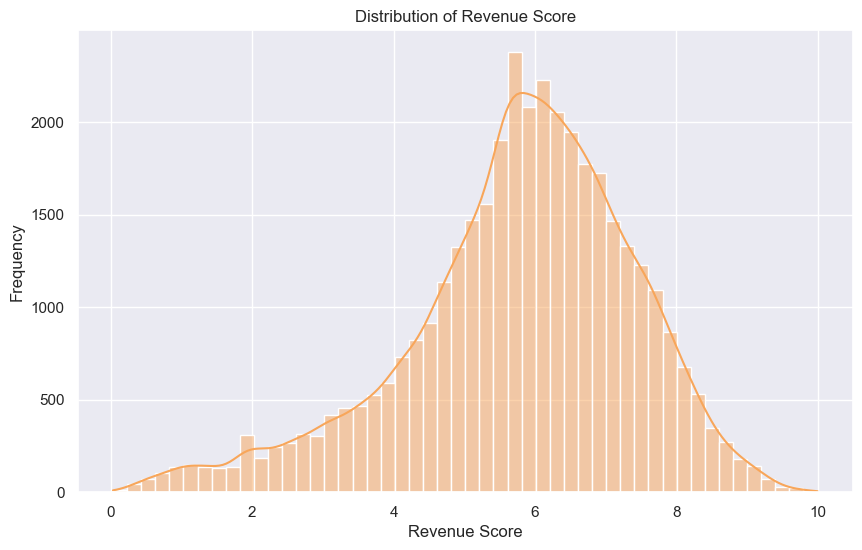

In [135]:
filtered_actor_statistics = actor_statistics[actor_statistics['revenue_score']>0]

# Create a histplot
plt.figure(figsize=(10, 6))
sns.histplot(filtered_actor_statistics['revenue_score'], bins=50, kde=True, color='#f8a65a')

# Add labels and title
plt.xlabel('Revenue Score')
plt.ylabel('Frequency')
plt.title('Distribution of Revenue Score')

# Show the plot
plt.show()

In [136]:
movies['Movie box office revenue'].isna().sum()

73340

In [137]:
movies[movies['Movie box office revenue']==0].shape[0] # 0 revenues are all missing values

0

In [138]:
revenue_score = filtered_actor_statistics[['Actor name', 'revenue_score']]

revenue_score

,Actor name,revenue_score
13,'Squeeks' the Caterpillar,6.254305
15,40 Glocc,4.605494
16,50 Cent,6.931420
18,A Martinez,5.847769
33,A. Delon Ellis Jr.,5.814812
...,...,...
133575,Şebnem Dönmez,4.154950
133580,Şevval Sam,2.494241
133587,Željko Ivanek,8.366399
133598,佐々木望,6.764742


### Limitations

Someone can play an unimportant role in many high revenues movies, it doesn't mean they are getting a lot of income from their movie. However, combined with other indicators, it can give us an idea of the success of someone. Note that we do not establish a causal relationship between the presence of an actor in a movie and the money the movie generated.

Moreover, we have a large number of missing values for movie revenues, which results in many actors not obtaining a revenue score in our dataset.

## 4. Exploring additional success metrics with restricted data

We delved into two other notions of success. However, due to limitations in the data collections, the data is restrictive and not representative of the entire world. We still present them here, emphasizing that it should be considered carefully when trying to make international comparisons.

## 4.a. [Oscars' winners and nominees](https://datahub.io/rufuspollock/oscars-nominees-and-winners)

### The dataset

In [97]:
#oscars = pd.read_csv('~/ADA2023/Project/Data/oscar_awards.csv')
oscars = pd.read_csv('Data/oscar_awards.csv')

In [98]:
oscars.columns

Index(['year', 'category', 'winner', 'entity'], dtype='object')

**Oscar nominations and awards by gender**

In [99]:
oscars_actors = oscars[(oscars['category'].str.contains("ACTOR")) | (oscars['category'].str.contains("ACTRESS"))]

In [100]:
# Group by gender and year and calculate the number of total observations and winners
mask = oscars_actors['category'].str.contains("ACTOR")

oscars_actors.loc[:, 'gender'] = 'Female'
oscars_actors.loc[mask, 'gender'] = 'Male'

oscars_per_year_gender = oscars_actors.groupby(['year', 'gender'])['winner'].agg(['count', 'sum']).reset_index()
oscars_per_year_gender = oscars_per_year_gender.rename(columns={'count': 'Nominees', 'sum': 'Winners'})

In [101]:
oscars_per_year_gender

,year,gender,Nominees,Winners
0,1927,Female,3,1
1,1927,Male,2,1
2,1928,Female,6,1
3,1928,Male,5,1
4,1929,Female,6,1
...,...,...,...,...
175,2015,Male,10,2
176,2016,Female,10,2
177,2016,Male,10,2
178,2017,Female,10,2


Until 1975, there was only one category for actors and one for actresses. Nowadays, there are leading and supporting categories for each gender. We choose to consider both categories as Oscar winner indistinctively.

**Merge with CMU Movie Corpus**

In [139]:
characters_oscars = characters.merge(oscars_actors, left_on='Actor name', right_on='entity', how='left')

print('There are {}% of Oscar nominees or winners in the movies dataset.'.format(round(100 - characters_oscars['entity'].isna().sum()/characters_oscars.shape[0] * 100,2)))

There are 14.31% of Oscar nominees or winners in the movies dataset.


In [140]:
characters_oscars_test = characters.merge(oscars_actors, left_on='Actor name', right_on='entity', how='right')

print('Only {}% of Oscar nominees or winners ({}) do not appear in our movies dataset.'.format(round(characters_oscars_test['Actor name'].isna().sum()/characters_oscars_test.shape[0] * 100,2), characters_oscars_test['Actor name'].isna().sum()))

Only 0.04% of Oscar nominees or winners (28) do not appear in our movies dataset.


In [141]:
characters_oscars_test[characters_oscars_test['Actor name'].isna()][['entity', 'year', 'winner']]

,entity,year,winner
3940,Anne Shirley,1937,False
3976,Dame May Whitty,1937,False
5774,Charles Chaplin,1940,False
6037,Albert Basserman,1940,False
8259,Dame May Whitty,1942,False
18920,Sir Laurence Olivier,1956,False
19830,Vittorio De Sica,1957,False
24975,Dame Edith Evans,1963,False
25816,Dame Edith Evans,1964,False
27123,Anouk Aimee,1966,False


A few Oscar winners and nominees don't appear in our dataset. Movies were extracted from a dump of Freebase in 2012. If actors began their career after this date, they can't appear in the CMU Movies Corpus. For missing values before that, the source of the missing values is unclear, but the number of actors concerned is small enough to be ignored.

In [142]:
characters_movie_oscars = characters_oscars.merge(movies, on= 'Freebase movie ID')

### Preparing the features and outcome

**Variables of interest**

In [143]:
characters_movie_oscars.columns

Index(['Wikipedia movie ID_x', 'Freebase movie ID', 'Movie release date_x',
       'Character name', 'Actor date of birth', 'Actor gender', 'Actor height',
       'Actor ethnicity', 'Actor name', 'Actor age at movie release',
       'Freebase character/actor map ID', 'Freebase character ID',
       'Freebase actor ID', 'e.id', 'Wikipedia Movie id', 'Movie name_x',
       'charName', 'fullName', 'occurences', 'max', 'Persona', 'year',
       'category', 'winner', 'entity', 'gender', 'Wikipedia movie ID_y',
       'Movie name_y', 'Movie release date_y', 'Movie box office revenue',
       'Movie runtime', 'Movie languages', 'Movie countries', 'Movie genres'],
      dtype='object')

Actors are nominated for an Oscar for a specific performance in a single film. The period of eligibility is the full previous calendar year from January 1 to December 31 (Source: [Wikipedia](https://en.wikipedia.org/wiki/Academy_Award_for_Best_Actor#:~:text=The%20first%20winner%20was%20Emil,other%20actors%20have%20won%20twice.)). Hence, it is important to associate a nomination for or an award to a specific movie and year, and to use only features that are associated to it to predict the Oscar outcome. For instance, someone's age on the movie release date might matter, but their birthdate does not. Similarly, the longevity of the actor's career, comprising years after the Oscar is not relevant. 

Another option would be to aggregate Oscars over the actors' career, but we know winning an Oscar is heavily dependent on the movie they play in. It would be hard to correctly associate the characteristics of the movie for which the Oscar has been won to the actor's entire career.

Hence, we isolate the following variables that might explain the nomination or winning of an Oscar:
- Actor's age on movie release date
- Actor's gender
- Actor's ethnicity
- Actor's height, as it is the only variable that allows us to proxy for the physique of the actor
- Movie language
- Country of the movie
- Genre of the movie
- Movie runtime
- Persona: type of role played

Movie release date could matter relatively to a year, for instance movies released in January might have more time to convince the jury. However, given that we do not consistently have the month present in our data, we ignore this variable.

In [144]:
characters_movie_oscars['Movie release date'] = pd.to_datetime(characters_movie_oscars['Movie release date_x'], format='mixed', errors='coerce')

# How much month data do we have?
characters_movie_oscars['date_content'] = 'Unknown'
characters_movie_oscars.loc[characters_movie_oscars['Movie release date'].dt.month.notna(), 'date_content'] = 'Full Date'
characters_movie_oscars.loc[characters_movie_oscars['Movie release date'].dt.month.isna(), 'date_content'] = 'Year'
characters_movie_oscars.loc[(characters_movie_oscars['Movie release date'].dt.month == 1) & (characters_movie_oscars['Movie release date'].dt.day == 1) , 'date_content'] = 'Year' # automatically imputed
characters_movie_oscars.loc[characters_movie_oscars['Movie release date'].isnull(), 'date_content'] = 'Missing'

count_occurrences = characters_movie_oscars['date_content'].value_counts()

print(count_occurrences)

date_content
Full Date    315439
Year         162645
Missing       10358
Name: count, dtype: int64


In [145]:
# Changing the dictionnary in the data into values
for variable in list(['languages', 'countries', 'genres']): 

    full_var = 'Movie ' + variable
    characters_movie_oscars[full_var] = characters_movie_oscars[full_var].apply(lambda x: {variable: None} if not x else x)
    characters_movie_oscars[variable] = characters_movie_oscars[full_var].apply(lambda x: list(x.values())[0]) # only keeping the first genre or country

# Remove ' Language' from values in the 'Language' column
characters_movie_oscars['languages'] = characters_movie_oscars['languages'].str.replace(' Language', '')
characters_movie_oscars['languages'] = characters_movie_oscars['languages'].str.replace(' language', '')

In [146]:
# Choose the relevant features
actors_features = ['Movie release date_x', 'Actor gender', 'Actor age at movie release', 'Actor height', 'Actor ethnicity', 'Movie runtime', 'languages', 'countries', 'genres', 'Persona']

X_ = characters_movie_oscars[actors_features].copy()

# Prepare the features vector for training by converting the value to floats
X_['Actor age at movie release'] = X_['Actor age at movie release'].astype('category')

X_['Actor gender'] = X_['Actor gender'].map(gender_mapping)

# Fit the encoder to the categorical variables and transform them
label_encoder = LabelEncoder()
X_['Encoded language'] = label_encoder.fit_transform(X_['languages'])
X_['Encoded genre'] = label_encoder.fit_transform(X_['genres'])
X_['Encoded country'] = label_encoder.fit_transform(X_['countries'])
X_['Encoded ethnicity'] = label_encoder.fit_transform(X_['Actor ethnicity'])

In [147]:
# Store the dictionaries for more interpretability later
language_dict = dict(zip(X_['languages'], X_['Encoded language']))
country_dict = dict(zip(X_['countries'], X_['Encoded country']))
genre_dict = dict(zip(X_['genres'], X_['Encoded genre']))
ethnicity_dict = dict(zip(X_['Actor ethnicity'], X_['Encoded ethnicity']))

**Dealing with missing values**

For our classifier, we need to remove missing values. As we don't want to do imputations on personal characteristics, it requires to drop a substantial amount of observations. Hence, we do the analysis first on all variables but on the restricted sample with non-missing values, and second, on a selected number of variables that offer a bigger amount of non-missing observations.

In [148]:
X_all_var = X_.drop(['Movie release date_x', 'Actor ethnicity', 'genres', 'countries', 'languages'], axis=1)
X_select_var = X_.drop(['Movie release date_x', 'Actor ethnicity', 'genres', 'countries', 'languages', 'Encoded ethnicity', 'Actor height', 'Persona'], axis=1)

In [149]:
print(X_all_var.isna().sum())

Actor gender                   45610
Actor age at movie release    162202
Actor height                  297721
Movie runtime                  51815
Persona                       465043
Encoded language                   0
Encoded genre                      0
Encoded country                    0
Encoded ethnicity                  0
dtype: int64


In [150]:
# Removing missing values
X_all = X_all_var[~(X_all_var.isna().any(axis=1))].copy()
X_select = X_select_var[~(X_select_var.isna().any(axis=1))].copy()

**Preparing the outcome variable**

In [151]:
# We only consider someone a nominee/winner on the year direcly following a movie 
characters_movie_oscars['post'] = ((characters_movie_oscars['year'] == characters_movie_oscars['Movie release date'].dt.year + 1)  & (characters_movie_oscars['year'].notnull())).astype(int)

In [152]:
#Prepare the outcome vector for training
characters_movie_oscars['nomination_status'] = characters_movie_oscars['winner'].map({0: 1, 1: 2})
characters_movie_oscars['nomination_status'].fillna(0, inplace=True)

# Store the dictionary
outcome_mapping = {0: 'gets nothing', 1: 'is nominated for an Oscar', 2: 'wins an Oscar'}

y_ = characters_movie_oscars['nomination_status'].astype('int')*characters_movie_oscars['post'] # winner x post movie

# We remove the same observations as for the features vector
y_all = y_[~(X_all_var.isna().any(axis=1))]
y_select = y_[~(X_select_var.isna().any(axis=1))]

### Predicting Oscars' nomination status with a Random Forest Classifier

We face a supervised classification problem and we expect non lininearity. Moreover, the features we consider don't have a spatial representation so no notion of distance. For these reason, a tree model is adequate. It is easily interpretable and allows to understand what features matter for getting an Oscar, which is ultimately what we are interested in.

In [153]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# Create and train a Random Forest Classifier
model_all = RandomForestClassifier(n_estimators=100, random_state=42)
model_all.fit(X_resampled, y_resampled)

# Make predictions on the test set
y_pred = model_all.predict(X_test)

# Evaluate the model's performance
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      4447
           1       0.02      0.04      0.02        56
           2       0.00      0.00      0.00        19

    accuracy                           0.95      4522
   macro avg       0.33      0.33      0.33      4522
weighted avg       0.97      0.95      0.96      4522



In [154]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_select, y_select, test_size=0.2, random_state=42)

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# Create and train a Random Forest Classifier
model_select = RandomForestClassifier(n_estimators=100, random_state=42)
model_select.fit(X_resampled, y_resampled)

# Make predictions on the test set
y_pred = model_select.predict(X_test)

# Evaluate the model's performance
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     58728
           1       0.01      0.05      0.02       279
           2       0.01      0.06      0.02        65

    accuracy                           0.98     59072
   macro avg       0.34      0.36      0.34     59072
weighted avg       0.99      0.98      0.98     59072



Note that we have a very imbalanced dataset because most people have no Oscar nor nomination, so our classifier almost exclusively predicts 0. It is hard to predict Oscars accurately given the information we have. Even after balancing the dataset, the accuracy for nomination and win is very low. 

In [155]:
print('Balanced data')
print((y_resampled == 2).sum())
print((y_resampled == 1).sum())
print((y_resampled == 0).sum())
print('--- \n Original data')
print((y_train == 2).sum())
print((y_train == 1).sum())
print((y_train == 0).sum())

Balanced data
234976
234976
234976
--- 
 Original data
274
1035
234976


In [156]:
feature_importances = model_all.feature_importances_

# Create a DataFrame to display feature importances with feature names
importance_df_all = pd.DataFrame({'Feature': X_all.columns, 'Importance': feature_importances})

# Sort the features by importance in descending order
importance_df_all = importance_df_all.sort_values(by='Importance', ascending=False)

In [157]:
feature_importances = model_select.feature_importances_

# Create a DataFrame to display feature importances with feature names
importance_df_select = pd.DataFrame({'Feature': X_select.columns, 'Importance': feature_importances})

# Sort the features by importance in descending order
importance_df_select = importance_df_select.sort_values(by='Importance', ascending=False)

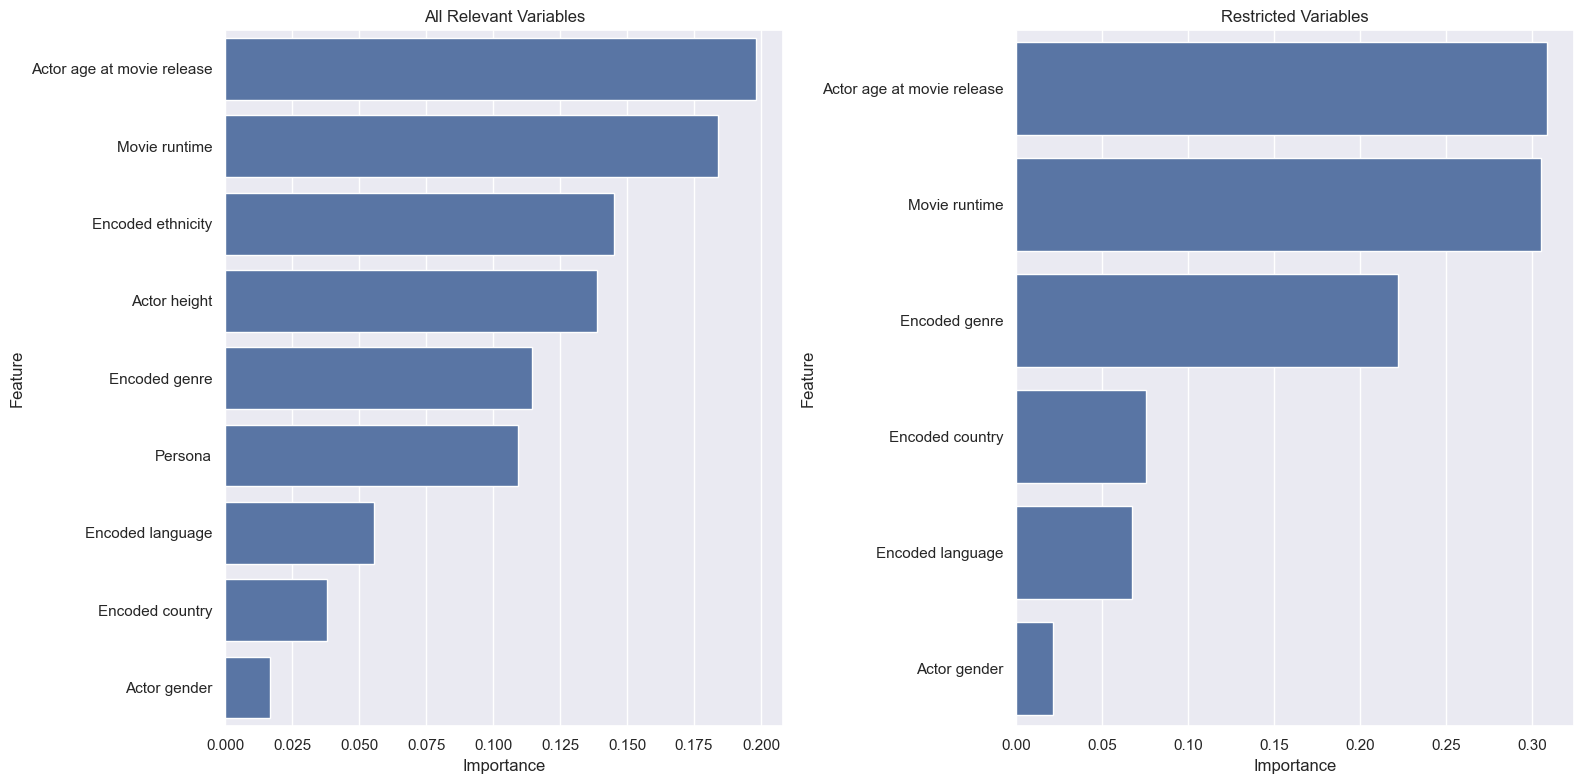

In [158]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot for All Relevant Variables
sns.barplot(x='Importance', y='Feature', data=importance_df_all, ax=axes[0])
axes[0].set_title('All Relevant Variables')

# Plot for Restricted Variables
sns.barplot(x='Importance', y='Feature', data=importance_df_select, ax=axes[1])
axes[1].set_title('Restricted Variables')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In both analyses, the most important feature is the actor's age when the movie is released, closely followed by the movie runtime. On the other side of the spectrum, gender does not seem to explain much of Oscars' winning. It makes sense that gender since both men and women win as many Oscars and are not competing. Overall, it seems like both movie and actor characteristics are important to predict the nomination and award of Oscars.

### Creating a score index

We want to create a score between 0 and 10 based on the probability of being nominated or winning an Oscar for a given movie and actor. To do so, we compute a weighted sum of the probabilities to have nothing, get a nomination, or get an award given by our model.  

In [159]:
X_all.columns

Index(['Actor gender', 'Actor age at movie release', 'Actor height',
       'Movie runtime', 'Persona', 'Encoded language', 'Encoded genre',
       'Encoded country', 'Encoded ethnicity'],
      dtype='object')

In [160]:
def transform_features_all(input_features):
    """Reverses encoding for Oscar prediction"""
    string_indices = [0, 5, 6, 7, 8] 
    
    for index in string_indices:
        if input_features[index] in gender_mapping:
            input_features[index] = gender_mapping[input_features[index]]
        elif input_features[index] in language_dict:
            input_features[index] = language_dict[input_features[index]]
        elif input_features[index] in genre_dict:
            input_features[index] = genre_dict[input_features[index]]
        elif input_features[index] in country_dict:
            input_features[index] = country_dict[input_features[index]]
        elif input_features[index] in ethnicity_dict:
            input_features[index] = ethnicity_dict[input_features[index]]

    return input_features

def transform_features_select(input_features):
    """Reverses encoding for Oscar prediction"""
    string_indices = [0, 3, 4, 5] # to change if order of variables changes
    
    for index in string_indices:
        if input_features[index] in gender_mapping:
            input_features[index] = gender_mapping[input_features[index]]
        elif input_features[index] in language_dict:
            input_features[index] = language_dict[input_features[index]]
        elif input_features[index] in genre_dict:
            input_features[index] = genre_dict[input_features[index]]
        elif input_features[index] in country_dict:
            input_features[index] = country_dict[input_features[index]]

    return input_features

def concatenate_values_all(row):
    """Concatenate values and transform the features into something readable by our model"""
    InputArray = [row['Actor gender'], row['Actor age at movie release'], row['Actor height'],row['Movie runtime'], row['Persona'], row['languages'], row['genres'],row['countries'], row['Actor ethnicity']]
    return transform_features_all(InputArray)


def concatenate_values_select(row):
    InputArray = [row['Actor gender'], row['Actor age at movie release'],row['Movie runtime'], row['languages'], row['genres'],row['countries']]
    return transform_features_select(InputArray)

In [161]:
characters_movie_oscars['InputArray_all'] = characters_movie_oscars.apply(concatenate_values_all, axis=1)

In [162]:
characters_movie_oscars['InputArray_select'] = characters_movie_oscars.apply(concatenate_values_select, axis=1)

In [163]:
def oscar_score_all(row):
    if not any(pd.isna(row)):
        proba = model_all.predict_proba([row['InputArray_all']])
        return 100*proba[0][2] + 25*proba[0][1] # for a smooth curve
    else:
        return None
    
def oscar_score_select(row):
    if not any(pd.isna(row)):
        proba = model_select.predict_proba([row['InputArray_select']])
        return 100*proba[0][2] + 25*proba[0][1] 
    else:
        return None

In [164]:
# Suppress scikit-learn warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

characters_movie_oscars['score_all'] = characters_movie_oscars.apply(oscar_score_all, axis=1)
characters_movie_oscars['score_select'] = characters_movie_oscars.apply(oscar_score_select, axis=1)

In [165]:
print(characters_movie_oscars['score_all'].notna().sum())
print(characters_movie_oscars['score_select'].notna().sum())

8319
8319


In [166]:
oscar_score_by_character_all = characters_movie_oscars.groupby('Actor name')['score_all'].sum()
oscar_score_by_character_select = characters_movie_oscars.groupby('Actor name')['score_select'].sum()

In [167]:
print(oscar_score_by_character_all[oscar_score_by_character_all==0].count())

# have to discard 0s (missing explanatory variables) to reshape the score 
oscar_score_by_character_all = oscar_score_by_character_all[oscar_score_by_character_all>0].reset_index()
oscar_score_by_character_select = oscar_score_by_character_select[oscar_score_by_character_select>0].reset_index()

133768


In [168]:
np.random.seed(42)

oscar_score_by_character_all['OscarScore_all'], lambda_value_all = boxcox(oscar_score_by_character_all['score_all'])
oscar_score_by_character_all['OscarScore_scaled_all'] = (oscar_score_by_character_all['OscarScore_all'] - oscar_score_by_character_all['OscarScore_all'].min()) / (oscar_score_by_character_all['OscarScore_all'].max() - oscar_score_by_character_all['OscarScore_all'].min()) * 10 
oscar_score_by_character_all = oscar_score_by_character_all[['Actor name', 'OscarScore_scaled_all']]

oscar_score_by_character_select['OscarScore_select'], lambda_value_select = boxcox(oscar_score_by_character_select['score_select'])
oscar_score_by_character_select['OscarScore_scaled_select'] = (oscar_score_by_character_select['OscarScore_select'] - oscar_score_by_character_select['OscarScore_select'].min()) / (oscar_score_by_character_select['OscarScore_select'].max() - oscar_score_by_character_select['OscarScore_select'].min()) * 10
oscar_score_by_character_select = oscar_score_by_character_select[['Actor name', 'OscarScore_scaled_select']]

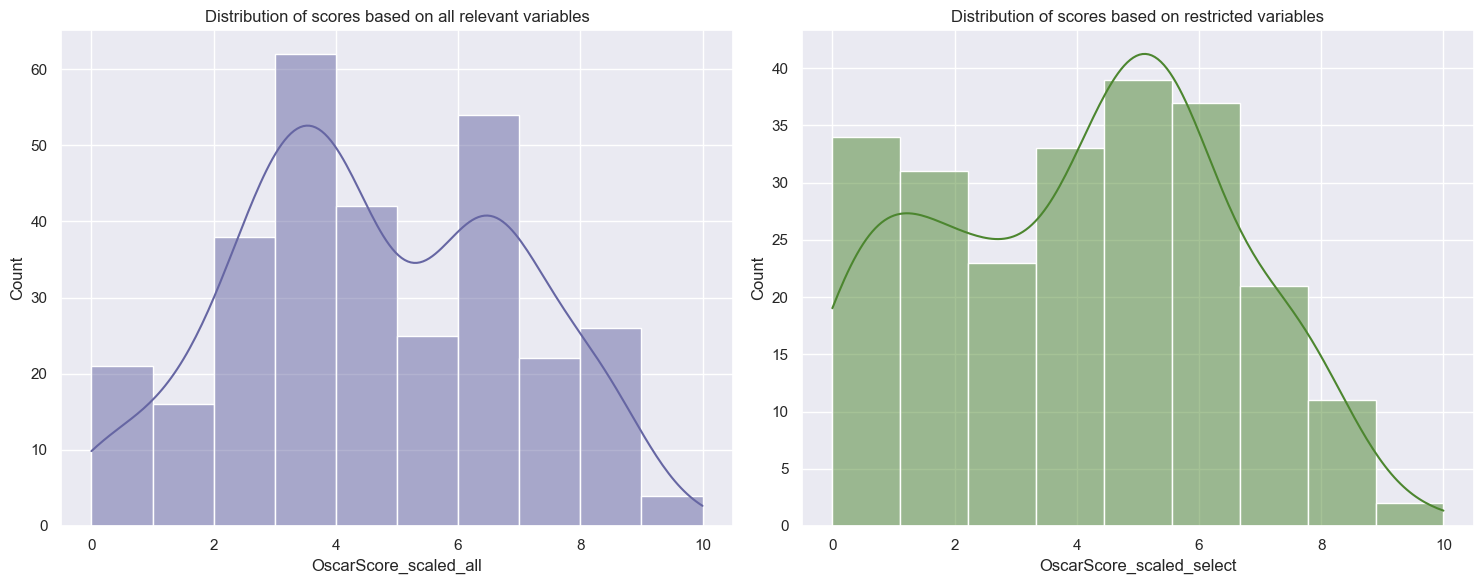

In [170]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.histplot(oscar_score_by_character_all['OscarScore_scaled_all'], kde=True, ax=axes[0], color='#6666a3')
axes[0].set_title('Distribution of scores based on all relevant variables')

sns.histplot(oscar_score_by_character_select['OscarScore_scaled_select'], kde=True, ax=axes[1], color='#4c862f')
axes[1].set_title('Distribution of scores based on restricted variables')

plt.tight_layout()
plt.show()

### Limitations of the dataset

The Oscars take place in the US and are usually political. It is less likely for popular foreign actors to win an award outside the best international film category, even if some film industries are very big outside of Hollywood, such as Bollywood and Nollywood.

We haven't found an exhaustive dataset of awards. We might decide to extend the analysis to more award ceremonies but none is exempt from this national preference: The Australian Film Institute Awards, The BAFTA Film Awards (UK), the Césars Film Awards (France), the Golden Bears (Germany), the Golden Globes (US), the Golden Lions (Venice), the Palme d'Or awards (France), the Sundance Film Festival awards (independent movies), Filmfare (Hindi), etc.

We do not aim at doing an exhaustive analysis, but it is important here to understand that we have a Western bias and we might need to use other indicators to better understand success of actors outside of Hollywood. 

Using our score indices complementarily is key to go past potential biases.

In [171]:
# What are movie nationalities of actors that won an Oscar?
oscar_winers = characters_oscars[characters_oscars['winner'] == True].merge(movies, on='Freebase movie ID', how='left') 

# Flatten the dictionaries and count countries occurrences
countries_counts = Counter(country for countries_dict in oscar_winers["Movie countries"] for country in countries_dict.values())

filtered_countries_counts = {country: count for country, count in countries_counts.items() if count > 500}
sorted_countries_counts = dict(sorted(filtered_countries_counts.items(), key=lambda item: item[1], reverse=True))

sorted_countries_counts # Indian movies are not represented at all despite their big industry

{'United States of America': 12598,
 'United Kingdom': 2393,
 'France': 667,
 'Germany': 530,
 'Italy': 507}

Another issue is that we do not have mapping of ethnicity so we even though we know this feature matters, we cannot really explain how. Additionally, it is largely missing, so we did not include it in the analysis with restricted variables.

In [172]:
result = characters_movie_oscars.groupby('Actor ethnicity')['Actor name'].agg(['first', 'count']).sort_values(by='count', ascending=False).nlargest(5, 'count')

for ethnicity, values in result.iterrows():
    print(f"For '{ethnicity}':")
    print(f"  - First actor: {values['first']}")
    print(f"  - Total count: {values['count']}")
    print("----")
    
# Indian, white, black? Seems more precise than this

For '/m/0dryh9k':
  - First actor: Mohanlal
  - Total count: 16555
----
For '/m/041rx':
  - First actor: Seth Green
  - Total count: 12244
----
For '/m/0x67':
  - First actor: Ice Cube
  - Total count: 10947
----
For '/m/02w7gg':
  - First actor: Pete Postlethwaite
  - Total count: 7599
----
For '/m/033tf_':
  - First actor: Matt Stone
  - Total count: 5659
----


## 5. Synthesizing the insights

Our goal is to offer a more nuanced understanding on the determinants of success. By combining diverse metrics, we strive for a exhaustive examination given the limitations in each isolated measure. Additionally, various success notions may not always exhibit strong correlations. For instance, an actor associated with movies generating a lot of money may not necessarily enjoy a lengthy career or consistently receive good ratings.

In [173]:
# Filtering the useless columns for longevity scores
sel = ['actor_name', 'longv_score']
long_scores = freq_span_nbmv[sel]
long_scores = long_scores.rename(columns={'actor_name': 'Actor name', 'longv_score': 'Longevity Score'})
long_scores.sample()

,Actor name,Longevity Score
28215,Suhita Thatte,5.702138


In [174]:
# Merge the different success scores on 'Actor name'
pairplot_data = pd.merge(oscar_score_by_character_all, oscar_score_by_character_select, on='Actor name', how='outer', suffixes=('_all', '_select'))
pairplot_data = pd.merge(pairplot_data, revenue_score, on='Actor name', how='outer')
pairplot_data = pd.merge(pairplot_data, long_scores, on='Actor name', how='outer')
print(pairplot_data.head())

        Actor name  OscarScore_scaled_all  OscarScore_scaled_select  \
0  Adriana Barraza               2.637819                  0.012693   
1     Adrien Brody               4.778594                  1.451767   
2        Al Pacino               8.032299                  7.178834   
3        Alan Alda               3.600157                       NaN   
4       Alan Arkin               6.735317                  5.541458   

   revenue_score  Longevity Score  
0       6.999305         5.760684  
1       8.379440         7.431752  
2       8.913157         8.271459  
3       8.135975         8.267579  
4       8.222203         8.625023  


**Correlations between success scores**

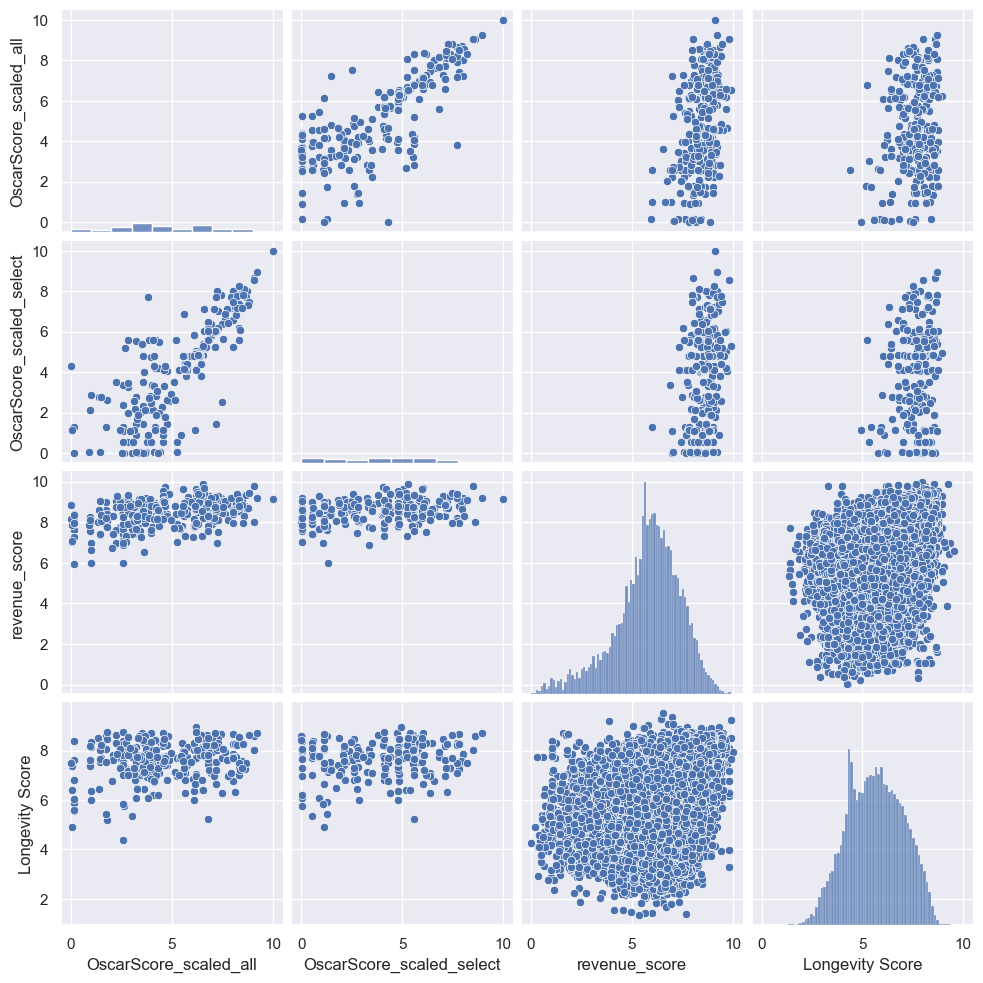

In [175]:
sns.pairplot(pairplot_data.drop('Actor name', axis=1))

plt.show()

As expected, the two Oscar score exhibit a large positive corelation. It is less clear for the relation between revenues and Oscars but we still observe a slightly positive slope in the graphs, indicating that higher revenue score are correlated with higher Oscar score (which is directly linked to the probability to get an Oscar).

The distribution of Oscars seems flat here as we do not have the score for many actors.

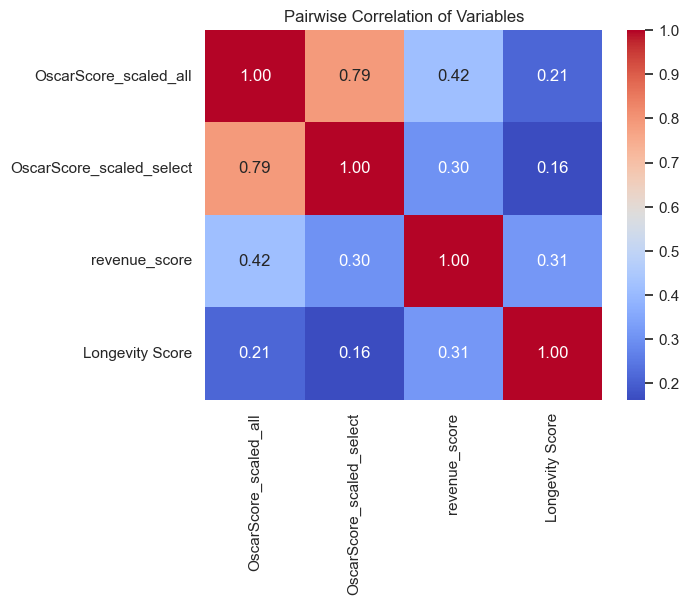

In [177]:
# Pairwise correlation plot
corr_matrix = pairplot_data.drop('Actor name', axis=1).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Pairwise Correlation of Variables')
plt.show()

**Illustration**

In [178]:
pairplot_data[pairplot_data['Actor name'].isin(['Julia Roberts', 'Meryl Streep'])]

,Actor name,OscarScore_scaled_all,OscarScore_scaled_select,revenue_score,Longevity Score
162,Julia Roberts,8.672413,7.715692,9.339858,7.515842
24618,Meryl Streep,NaN,NaN,9.057049,8.073598


In [192]:
def spider_chart(actor_name, df):
    # Extract data for the given actor
    actor_data = df[df['Actor name'] == actor_name]

    # Check if data for the actor is available
    if actor_data.empty:
        print(f"No data found for {actor_name}.")
        return

    # Variables and their values
    variables = ['OscarScore_scaled_all', 'OscarScore_scaled_select', 'revenue_score', 'Longevity Score']
    values = actor_data[variables].values.flatten()

    # If any variable is missing, replace with -1
    values = np.where(np.isnan(values), -1, values)

    # Number of variables
    num_vars = len(variables)

    # Compute angle of each axis
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # The plot is circular, so we need to "close the loop" and append the start
    values = np.concatenate((values, [values[0]]))
    angles += angles[:1]
    
    plt.figure(figsize=(8, 8))
    plt.polar(angles, values, marker='o', color='#b41515', linestyle='solid', linewidth=2)
    plt.fill(angles, values, color='#b41515', alpha=0.3)
    plt.xticks(angles[:-1], variables)
    plt.title(f'Score Spider Plot for {actor_name}')
    plt.show()

No data found for Julia Robersssss.


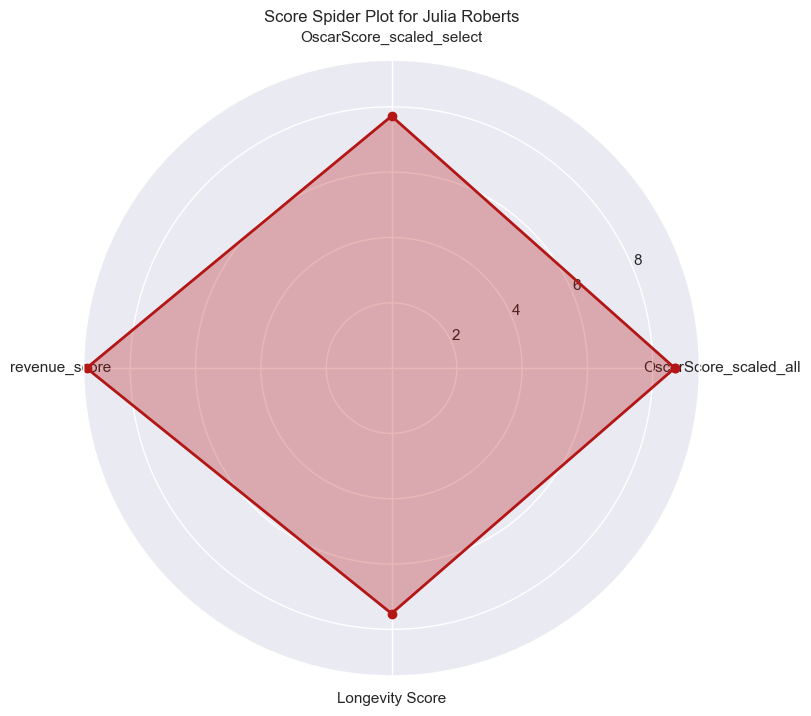

In [193]:
spider_chart('Julia Robersssss', pairplot_data)
spider_chart('Julia Roberts', pairplot_data)

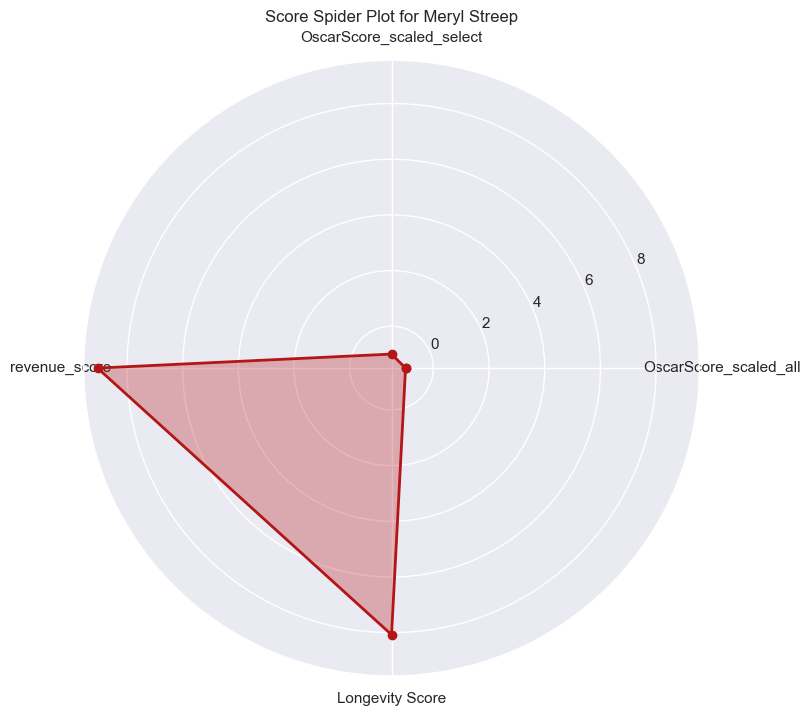

In [194]:
spider_chart('Meryl Streep', pairplot_data)

In [207]:
def multiple_spider_chart(actor_names, df):

    variables = ['OscarScore_scaled_all', 'OscarScore_scaled_select', 'revenue_score', 'Longevity Score']
    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)

    actor_colors = {
        actor_names[0] : '#000080',
        actor_names[1] : '#76a5af',
        #actor_names[2]: '#15b43f',
    }
    
    for actor_name in actor_names:
        actor_data = df[df['Actor name'] == actor_name]
        
        if actor_data.empty:
            print(f"No data found for {actor_name}. Skipping.")
            continue
        
        values = actor_data[variables].values.flatten()
        values = np.where(np.isnan(values), -1, values)
        num_vars = len(variables)
        angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

        values = np.concatenate((values, [values[0]]))
        angles += angles[:1]
        
        actor_color = actor_colors.get(actor_name, '#b41515') # red by default, if no color found

        ax.plot(angles, values, marker='o', linestyle='solid', linewidth=2, label=actor_name, color = actor_color)
        ax.fill(angles, values, alpha=0.4, color = actor_color)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(variables)
    ax.set_title('Score Spider Plots')
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
    plt.show()

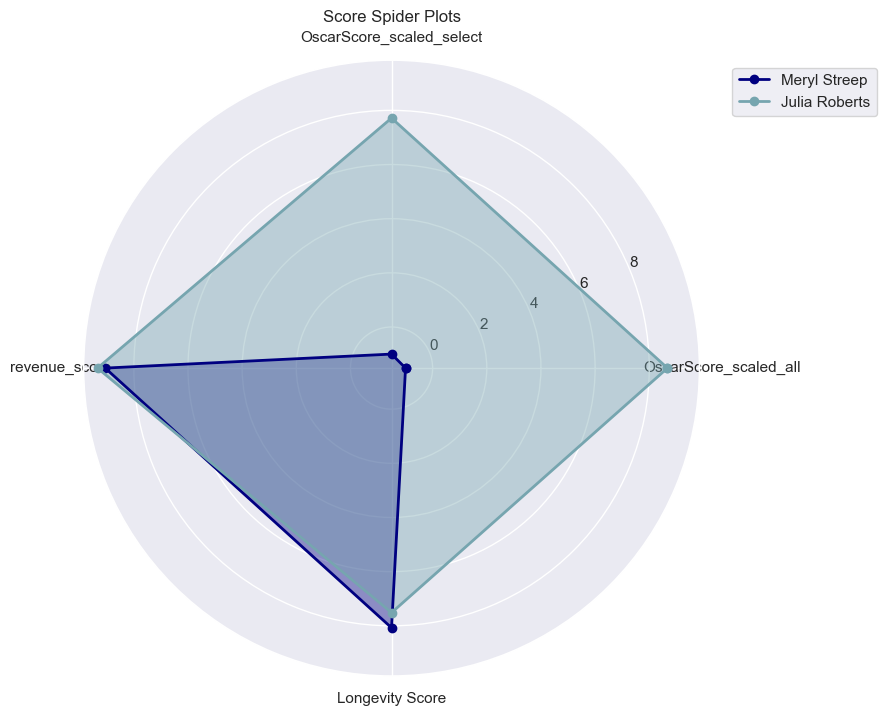

In [208]:
multiple_spider_chart(['Meryl Streep', 'Julia Roberts'], pairplot_data)